### Entities' cause commitment in public messaging
This notebook replicates the analysis in the paper: Zhao Wang, Jennifer Cutler, Aron Culotta. ["Are Words Commensurate with Actions? Quantifying Commitment to A Cause from Online Public Messaging"](www.google.com) IEEE International Conference on Data Mining Workshops (ACUMEN: Data science for human performance in social networks), 2017.<br><br>
The goal of this analysis is to identify potential "inauthentic" entities by comparing how do entities show commitment toward a cause in their tweets and in their actions.<br><br>
This notebook has been tested in **Python 3.4.3** only.<br><br>
The code below is exactly what was used to produce the tables and figures in the final version of the paper.<br><br>
**Data**<br>
Please see the paper for the details of data collection. This notebook assumes access to the pre-collected data and pre-trained word2vec model.<br> 
For the pre-collected data, please contact Zhao (zwang185@hawk.iit.edu) for access to this link:<br>
https://www.dropbox.com/sh/30t39m2ubrli74q/AADGFjYNJBwKdugpC3MYTxzea?dl=0<br>
For the pre-trained word2vec model, please download from this link:<br>
https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit<br>

Once you download the data, place it in a folder called data, in the same folder as this notebook.

### 7 sections of implementation and analysis:<br>
**Section 1: select cause-relevant tweets as training data<br>**
> 1.1 Get entities' information<br>
> 1.2 Read tweets for entities<br>
> 1.3 Score and sort tweets by cause-relevance<br>
> 1.4 Select and label each entity's top-n relevant tweets as training data<br>

**Section 2: feature engineering**
- 2.1 Linguistic features<br>
>2.1.1 Sentiment polarity<br>
>2.1.2 Pronouns <br>
>2.1.3 Cause keywords and Context of cause keywords <br>
>2.1.4 Social interactions <br>
>2.1.5 Part-Of-Speech tag <br>
- 2.2 Word embedding features<br>
>2.2.1 Tweet vector and tweet cause relevance score<br>
>2.2.2 Top-n(n=3,5) words, top-n words' vector and top-n words' cause relevance scores<br>
>2.2.3 Cause keywords(sim>=0.30), number of cause keywords, cause keywords' vector, cause keywords' relevance scores<br>
>2.2.4 Context words (window = 1), context vector, context words' contribution scores<br>

**Section 3: train and evaluate support classifier with manually labeled tweets**
>3.1 Evaluating linguistic features, word embedding features and combination of various features<br>
>3.2 Evaluate different classifiers<br>
>3.3 Analyze terms that have high coefficients<br>

**Section 4: train and evaluate commitment classifier with manually labeled tweets**
>4.1 Evaluating linguistic features, word embedding features and combination of various features<br>
>4.2 Evaluating different classifiers<br>
>4.3 Analyze terms that have high coefficients<br>

**Section 5: apply pre-trained classifiers to predict for unseen tweets**
>5.1 Apply support classifier to classify all brands' tweets into support and non-support classes<br>
>5.2 Apply commitment classifier to classify all brands' support tweets into high- and low- commitment classes<br>

**Section 6: aggregate each entity's cause-commitment tweets and compare with action scores to find inauthentic entities**
>6.1 Apply different aggregation methods to select entities that have high word-ratings<br>
>6.2 Sort entities with high word-ratings by their action-ratings and select top-n (high word-rating but low action-rating) as inauthentic entities

**7.Fit linear regression model to analyze how does entities' word commitment levels relate with action-ratings**<br><br>

In [97]:
import scipy
scipy.__version__

'0.19.1'

### Implementation
There are 3 datasets with entity&cause pairs: 
- brands with health cause<br>
- brands with eco cause<br> 
- member of congress (moc for short) with eco cause.<br> 

The following code will implement sections 1~6 for each dataset separately, and then implement section 7 for 3 datasets together.

In [11]:
import Cause
import nltk, logging, re, operator
from nltk.corpus import stopwords
import numpy as np
from IPython.display import display, HTML
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn import svm
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


from __future__ import print_function
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time

%matplotlib inline

logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')

In [2]:
BRAND_TWEET = './data/tweets.pruned.json.gz'
CONGRESS_TWEET = './data/congress_pruned.json'
GG_ECO_SCORE = './data/GoodGuide_ecobrands.csv'
GG_HEALTH_SCORE = './data/GoodGuide_healthbrands.csv'

W2V_PATH = './data/GoogleNews-vectors-negative300.bin'
ECO_terms = './data/eco_terms.txt'
LABELED_ecobrands = './data/brand_eco_labeled_tweets.csv'
LABELED_healthbrands = './data/brand_health_labeled_tweets.csv'
LABELED_ecoMOC = './data/congress_eco_labeled_tweets.csv'

In [3]:
eco_cause = "environment"
eco_keywords =["environment","ecosystem","biodiversity","habitats","climate","ecology","plantlife","pollution","rainforests"]

health_cause = "health"
health_keywords =["healthy","nutritious","lowfat","wholesome","organic","natural","vegan"]

In [4]:
eco_terms = Cause.read_eco_terms(ECO_terms)

In [5]:
mycv=KFold(n_splits=10, shuffle=True, random_state=42)

In [6]:
GN_model = Cause.load_GoogleNews_w2v(GN_W2V)

2017-09-23 21:30:26,968 INFO loading projection weights from /data/2/zwang/brand_score/GoogleNews/GoogleNews-vectors-negative300.bin


Start loading GoogleNews word2vec model.


2017-09-23 21:31:29,663 INFO loaded (3000000, 300) matrix from /data/2/zwang/brand_score/GoogleNews/GoogleNews-vectors-negative300.bin


The vocabulary size is: 3000000


#### Dataset 1: brands with health cause

**[brands-health]** section 1: select cause-relevant tweets as training data

In [7]:
healthbrand_score_dict, healthbrand_sector = Cause.get_brand_info(GG_HEALTH_SCORE,"screen_name","health score")

Get 169 brands with health score


In [8]:
healthbrand_nameid = Cause.get_healthbrand_nameid(GG_ECO_SCORE)

In [12]:
print("Sector distribution of health brands:")
health_sector = Counter()
health_sector.update(healthbrand_sector.values())
health_sector

Sector distribution of health brands:


Counter({'Food': 106, 'Personal Care': 63})

In [13]:
healthbrand_tweets_dict = Cause.read_brand_tweets(BRAND_TWEET, list(healthbrand_score_dict.keys()),cause="health")

read 500000 lines
read 1000000 lines
read 1500000 lines
read 2000000 lines
read 2500000 lines
Collected 429009 tweets for 142 health brands in total.


In [14]:
healthbrand_twID_dict, healthbrand_twID_twtext = Cause.dedup_tweets(healthbrand_tweets_dict,cause="health")

processed 100 entities
352160 non-duplicate tweets for 142 health brands


In [15]:
healthbrand_twID_twScore = Cause.score_tweet_by_relevance(healthbrand_twID_twtext,GN_model,health_keywords)

Note: This function takes some time to run. Please run for once, and save results to file.
processed 100000 tweets
processed 200000 tweets
processed 300000 tweets


In [16]:
healthbrand_twIDScore = Cause.sort_tweet_by_score(healthbrand_twID_twScore,healthbrand_twID_dict)

In [12]:
#Cause.select_topn_tweets(filename,healthbrand_twIDScore,healthbrand_twID_twtext,topn=3)

**[brands-health]** section 2: feature enginerring

> Labeled data for support classification

In [17]:
sup_healthbrand_list, sup_healthtweet_list, sup_healthlabel_list = Cause.data_for_sup_clf(LABELED_healthbrands,entity='health-brand')

Read 494 positive instances and 177 negative instances for support classification


In [18]:
sup_health_neg_terms, sup_health_pos_terms = Cause.get_freq_terms(sup_healthtweet_list,sup_healthlabel_list)

In [19]:
print("Most common terms in negative class (non-support):")
sup_health_neg_terms.most_common(20)

Most common terms in negative class (non-support):


[('_URL_', 74),
 ('delicious', 42),
 ('rt', 27),
 ('eat', 18),
 ('chocolate', 16),
 ('milk', 14),
 ('fresh', 14),
 ('food', 13),
 ('amp', 12),
 ('yummy', 11),
 ('_NUMBER_', 11),
 ('eating', 9),
 ('make', 9),
 ('products', 9),
 ('good', 8),
 ('fruit', 8),
 ('flavors', 8),
 ('new', 8),
 ('diet', 7),
 ('enjoy', 7)]

In [20]:
print("Most common terms in positive class (support):")
sup_health_pos_terms.most_common(20)

Most common terms in positive class (support):


[('_URL_', 315),
 ('healthy', 182),
 ('rt', 101),
 ('delicious', 74),
 ('_NUMBER_', 67),
 ('organic', 63),
 ('foods', 59),
 ('natural', 53),
 ('nutritious', 52),
 ('amp', 51),
 ('eat', 44),
 ('_HASHTAG_vegan', 43),
 ('snack', 40),
 ('_HASHTAG_organic', 39),
 ('skin', 39),
 ('ingredients', 37),
 ('free', 35),
 ('_HASHTAG_healthy', 33),
 ('food', 33),
 ('vegan', 32)]

> Labeled data for commitment classification

In [21]:
comt_healthbrand_list, comt_healthtweet_list, comt_healthlabel_list = Cause.data_for_commit_clf(LABELED_healthbrands,entity='health-brand')

Read 238 positive instances and 256 negative instances for commitment classification


In [22]:
comt_health_neg_terms, comt_health_pos_terms = Cause.get_freq_terms(comt_healthtweet_list,comt_healthlabel_list)

In [23]:
print("Most common terms in negative class (low-commitment):")
comt_health_neg_terms.most_common(20)

Most common terms in negative class (low-commitment):


[('_URL_', 161),
 ('healthy', 117),
 ('foods', 47),
 ('rt', 46),
 ('eat', 36),
 ('_NUMBER_', 32),
 ('delicious', 31),
 ('nutritious', 28),
 ('diet', 24),
 ('amp', 23),
 ('skin', 23),
 ('eating', 22),
 ('organic', 22),
 ('snack', 21),
 ('food', 20),
 ('_HASHTAG_vegan', 20),
 ('_HASHTAG_healthy', 17),
 ('great', 17),
 ('healthier', 17),
 ('veggies', 16)]

In [24]:
print("Most common terms in negative class (high-commitment):")
comt_health_neg_terms.most_common(20)

Most common terms in negative class (high-commitment):


[('_URL_', 161),
 ('healthy', 117),
 ('foods', 47),
 ('rt', 46),
 ('eat', 36),
 ('_NUMBER_', 32),
 ('delicious', 31),
 ('nutritious', 28),
 ('diet', 24),
 ('amp', 23),
 ('skin', 23),
 ('eating', 22),
 ('organic', 22),
 ('snack', 21),
 ('food', 20),
 ('_HASHTAG_vegan', 20),
 ('_HASHTAG_healthy', 17),
 ('great', 17),
 ('healthier', 17),
 ('veggies', 16)]

**[brands-health]** section 2.1: linguistic cues:<br>
2.1.1 Sentiment polarity <br>
2.1.2 Pronouns <br>
2.1.3 Cause keywords and Context of cause keywords <br>
2.1.4 Social interactions <br>
2.1.5 Part-Of-Speach tag <br>

In [19]:
print("Bag-of-words feature, serve as baseline.")
sup_BOW_tweet = sup_healthtweet_list
sup_bow_vectorizer,sup_BOW_tw_matrix = Cause.construct_feature_matrix(sup_BOW_tweet,my_max_df=0.75)
print(sup_BOW_tw_matrix.shape)

comt_BOW_tweet = comt_healthtweet_list
comt_bow_vectorizer, comt_BOW_tw_matrix = Cause.construct_feature_matrix(comt_BOW_tweet,my_max_df=0.75)
print(comt_BOW_tw_matrix.shape)

Bag-of-words feature, serve as baseline.
(671, 2610)
(494, 1983)


In [20]:
print("Sentiment polarity feature, for example: [\"It's not organic\"]")
print(Cause.mark_polarity(["It's not organic"],to_wd=0))
sup_BOW_addpola = Cause.mark_polarity(sup_healthtweet_list,to_wd=0)
sup_pola_vectorizer,sup_BOW_pola_matrix = Cause.construct_feature_matrix(sup_BOW_addpola,my_max_df=0.75)
print(sup_BOW_pola_matrix.shape)
comt_BOW_addpola = Cause.mark_polarity(comt_healthtweet_list,to_wd=0)
comt_pola_vectorizer,comt_BOW_pola_matrix = Cause.construct_feature_matrix(comt_BOW_addpola,my_max_df=0.75)
print(comt_BOW_pola_matrix.shape)

Sentiment polarity feature, for example: ["It's not organic"]
["It's _NEG_ organic"]
(671, 2611)
(494, 1984)


In [21]:
print("Pronoun feature, for example:")    
print(Cause.mark_pronouns(['Did you know? I did\'t but they do'], binary= False))
sup_BOW_addPron_tweet = Cause.mark_pronouns(sup_healthtweet_list, binary = False)
sup_pron_vectorizer,sup_pron_matrix = Cause.construct_feature_matrix(sup_BOW_addPron_tweet,my_max_df=0.75)
print(sup_pron_matrix.shape)
comt_BOW_addPron_tweet = Cause.mark_pronouns(comt_healthtweet_list, binary = False)
comt_pron_vectorizer, comt_pron_matrix = Cause.construct_feature_matrix(comt_BOW_addPron_tweet,my_max_df=0.75)
print(comt_pron_matrix.shape)

Pronoun feature, for example:
["Did you know? I did't but they do first__person second__person third__person"]
(671, 2610)
(494, 1983)


In [22]:
sup_BOW_addCont_tweet = Cause.mark_context(sup_healthtweet_list,eco_terms)
sup_cont_vectorizer,sup_BOW_cont_matrix = Cause.construct_feature_matrix(sup_BOW_addCont_tweet,my_max_df=0.75)

comt_BOW_addCont_tweet = Cause.mark_context(comt_healthtweet_list,eco_terms)
comt_cont_vectorizer, comt_BOW_cont_matrix = Cause.construct_feature_matrix(comt_BOW_addCont_tweet,my_max_df=0.75)

print("Eco keywords features, for example:")    
print(sup_healthtweet_list[80])
print(sup_BOW_addCont_tweet[80])
print(sup_BOW_cont_matrix.shape)
print(comt_BOW_cont_matrix.shape)

Eco keywords features, for example:
RT @organictvshow: RT if you love Organic   #organic #healthy #wholefoods #nutrition @WholeFoods @Stonyfield @Horizon_Organic @Honest @orga…
rt _MENTION_organictvshow rt if you love organic _HASHTAG_organic _HASHTAG_healthy _HASHTAG_wholefoods _HASHTAG_nutrition _MENTION_wholefoods _MENTION_stonyfield _MENTION_horizon_organic _MENTION_honest _MENTION_orga
(671, 2623)
(494, 1997)


In [23]:
print("Eco keywords' context features, for example:")
print(Cause.remove_keywords(["By walking or taking your bike you won't produce greenhouse http://foo.com gas emissions"],eco_terms))
sup_BOW_rmTopic_tweet = Cause.remove_keywords(sup_healthtweet_list, eco_terms)
sup_rmtopic_vectorizer,sup_BOW_rmtopic_matrix = Cause.construct_feature_matrix(sup_BOW_rmTopic_tweet,my_max_df=0.75)

comt_BOW_rmTopic_tweet = Cause.remove_keywords(comt_healthtweet_list, eco_terms)
comt_rmtopic_vectorizer, comt_BOW_rmtopic_matrix = Cause.construct_feature_matrix(comt_BOW_rmTopic_tweet,my_max_df=0.75)

print(sup_BOW_rmtopic_matrix.shape)
print(comt_BOW_rmtopic_matrix.shape)

Eco keywords' context features, for example:
["by walking or taking your bike you won't produce   _URL_   left_context_produce right_context__url_ left_context__url_"]
(671, 2616)
(494, 1991)


In [24]:
sup_BOW_self_tweet_once = Cause.selfmention(sup_healthbrand_list,healthbrand_nameid,sup_healthtweet_list, count="once")
sup_BOW_self_tweet_all = Cause.selfmention(sup_healthbrand_list,healthbrand_nameid,sup_healthtweet_list, count="all")

comt_BOW_self_tweet_once = Cause.selfmention(comt_healthbrand_list,healthbrand_nameid,comt_healthtweet_list, count="once")
comt_BOW_self_tweet_all = Cause.selfmention(comt_healthbrand_list,healthbrand_nameid,comt_healthtweet_list, count="all")

print("Selfmention features, for example:")
print(sup_healthtweet_list[4])
print(sup_BOW_self_tweet_once[4])
print(sup_BOW_self_tweet_all[4])

Selfmention features, for example:
NEW! IZZE Sparkling Water Beverage. Certified USDA organic and delicious. #organic #SparkleBrightly 💧✨ http://t.co/rkeeMm7lOu
NEW! IZZE Sparkling Water Beverage. Certified USDA organic and delicious. #organic #SparkleBrightly 💧✨ http://t.co/rkeeMm7lOu _SELF_
_SELF_NEW! _SELF_IZZE _SELF_Sparkling _SELF_Water _SELF_Beverage. _SELF_Certified _SELF_USDA _SELF_organic _SELF_and _SELF_delicious. _SELF_#organic _SELF_#SparkleBrightly _SELF_💧✨ _SELF_http://t.co/rkeeMm7lOu 


In [25]:
sup_BOW_pos_tags,sup_BOW_pos_wdtags = Cause.mark_pos(sup_healthtweet_list)
sup_pos_vectorizer,sup_BOW_pos_matrix = Cause.construct_feature_matrix(sup_BOW_pos_wdtags,my_max_df=0.75)

comt_BOW_pos_tags, comt_BOW_pos_wdtags = Cause.mark_pos(comt_healthtweet_list)
comt_pos_vectorizer, comt_BOW_pos_matrix = Cause.construct_feature_matrix(comt_BOW_pos_wdtags,my_max_df=0.75)

print("Part-of-speech tagging features, for example:")
print(sup_healthtweet_list[0])
print(sup_BOW_pos_tags[0])
print(sup_BOW_pos_wdtags[0])
print(sup_BOW_pos_matrix.shape)
print(comt_BOW_pos_matrix.shape)

Part-of-speech tagging features, for example:
@emilyhalford Because our products contain dairy, they are not vegan!
NN IN PRP$ NNS VBP NN PRP VBP RB JJ 
_MENTION_emilyhalford NN because IN our PRP$ products NNS contain VBP dairy NN they PRP are VBP not RB vegan JJ 
(671, 2629)
(494, 2004)


**[brands-health]** section 2.1: GrisearchCV to find best parameters for countvectorizer

In [26]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression()),
])

parameters = {
    'vect__min_df': (1, 3, 5,10,0.3),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__tokenizer': (None,Cause.tw_tokenize_with_features),
    #'vect__max_features': (None, 1000, 2000, 3000),
    #'vect__ngram_range': ((1, 1), (1, 2),(1,3)),  # unigrams or bigrams
    #'vect__binary': (True, False),
    
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),

    'lr__penalty': ('l2', 'l1'),
    'lr__class_weight': ("balanced",None)
}

In [27]:
# GridsearchCV for support classification
Cause.do_grid_search(pipeline,parameters,data = sup_healthtweet_list, label = sup_healthlabel_list, score='f1')

Performing grid search...
pipeline: ['vect', 'lr']
parameters:
{'lr__class_weight': ('balanced', None),
 'lr__penalty': ('l2', 'l1'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__min_df': (1, 3, 5, 10, 0.3),
 'vect__tokenizer': (None,
                     <function tw_tokenize_with_features at 0x7f2ea0910b70>)}
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    6.0s finished


done in 7.233s

Best score: 0.901
Best parameters set:
	lr__class_weight: None
	lr__penalty: 'l2'
	vect__max_df: 0.5
	vect__min_df: 1
	vect__tokenizer: None


In [36]:
# GridsearchCV for commitment classification
#Cause.do_grid_search(pipeline,parameters,data = comt_healthtweet_list, label = comt_healthlabel_list, score='f1')

**[brands-health]** section 2.2: word2vec features: <br>
2.2.1 Tweet vector and tweet cause relevance score <br>
2.2.2 Top-n(n=3,5) words, top-n words' vector and top-n words' cause relevance scores <br>
2.2.3 Cause keywords(sim>=0.30), number of cause keywords, cause keywords' vector, cause words' relevance scores <br>
2.2.4 Context words (window = 1), context vector, context words' contribution scores <br>

In [32]:
print("Tweet vector:")
sup_W2V_tw_vector = Cause.construct_tw_vector(sup_healthtweet_list,GN_model)
print(sup_W2V_tw_vector.shape)
comt_W2V_tw_vector = Cause.construct_tw_vector(comt_healthtweet_list,GN_model)
print(comt_W2V_tw_vector.shape)

Tweet vector:
(671, 300)
(494, 300)


In [33]:
print("Tweet cause-relevance score:")
sup_W2V_tw_score = Cause.calculate_tw_w2v_score(sup_healthtweet_list,GN_model,health_keywords)
print((sup_W2V_tw_score.shape))
comt_W2V_tw_score = Cause.calculate_tw_w2v_score(comt_healthtweet_list,GN_model,health_keywords)
print((comt_W2V_tw_score.shape))
print(sup_healthtweet_list[10])
print(sup_W2V_tw_score[10])

Tweet cause-relevance score:
(671, 1)
(494, 1)
@ASButtland chips (sugar, chocolate liquor, cocoa butter, soy lecithin, natural flavor) I'd recommend checking the package as ingredients...
[ 0.634]


In [34]:
print("Rand words by cause-relevance:\nFor example:")
sup_tweet_rankedwd_list = Cause.rank_match_words(sup_healthtweet_list, GN_model, health_keywords)
comt_tweet_rankedwd_list = Cause.rank_match_words(comt_healthtweet_list, GN_model, health_keywords)
print(sup_healthtweet_list[0])
print(sup_tweet_rankedwd_list[0])

Rand words by cause-relevance:
For example:
@emilyhalford Because our products contain dairy, they are not vegan!
[('vegan', '0.694'), ('dairy', '0.467'), ('products', '0.321'), ('contain', '0.169')]


In [35]:
print("Top-n words in each tweet:\nFor example:")
sup_W2V_topnwd, sup_W2V_topnwd_scores = Cause.get_topn_words(sup_tweet_rankedwd_list,n=3)
sup_topn_vectorizer,sup_W2V_topnwd_matrix = Cause.construct_feature_matrix(sup_W2V_topnwd,my_max_df=0.75)
print(sup_healthtweet_list[0])
print(sup_tweet_rankedwd_list[0])
print(sup_W2V_topnwd[0])
print(sup_W2V_topnwd_scores[0])

print(sup_W2V_topnwd_matrix.shape)

comt_W2V_topnwd, comt_W2V_topnwd_scores = Cause.get_topn_words(comt_tweet_rankedwd_list,n=3)
comt_topn_vectorizer, comt_W2V_topnwd_matrix = Cause.construct_feature_matrix(comt_W2V_topnwd,my_max_df=0.75)
print(comt_W2V_topnwd_matrix.shape)

Top-n words in each tweet:
For example:
@emilyhalford Because our products contain dairy, they are not vegan!
[('vegan', '0.694'), ('dairy', '0.467'), ('products', '0.321'), ('contain', '0.169')]
vegan dairy products 
[ 0.694  0.467  0.321]
(671, 419)
(494, 274)


In [38]:
print("Each tweet is represented by mean of top-n words' vectors:")
sup_W2V_topnwd_vectors = Cause.get_topn_vectors(sup_tweet_rankedwd_list,GN_model,n=3)
print(sup_W2V_topnwd_vectors.shape)
comt_W2V_topnwd_vectors = Cause.get_topn_vectors(comt_tweet_rankedwd_list,GN_model,n=3)
print(comt_W2V_topnwd_vectors.shape)

Each tweet is represented by mean of top-n words' vectors:
(671, 300)
(494, 300)


In [39]:
print("Words with cause-relevance score >= 0.3 serve as cause keywords:\nOrganized as:[relevance-score, leftword_contribution, rightword_contribution].\nFor example:")
sup_W2V_topicwd_list,sup_tweet_topicwd_tp_list = Cause.get_topic_words(sup_healthtweet_list,GN_model,health_keywords,threshold = 0.30)
sup_topic_vectorizer,sup_Topicwd_matrix = Cause.construct_feature_matrix(sup_W2V_topicwd_list,my_max_df=0.75)
print(sup_healthtweet_list[10])
print(sup_W2V_topicwd_list[10])
print(sup_tweet_topicwd_tp_list[10])
print(sup_Topicwd_matrix.shape)

comt_W2V_topicwd_list, comt_tweet_topicwd_tp_list = Cause.get_topic_words(comt_healthtweet_list,GN_model,health_keywords,threshold = 0.30)
comt_topic_vectorizer, comt_Topicwd_matrix = Cause.construct_feature_matrix(comt_W2V_topicwd_list,my_max_df=0.75)
print(comt_Topicwd_matrix.shape)

Words with cause-relevance score >= 0.3 serve as cause keywords:
Organized as:[relevance-score, leftword_contribution, rightword_contribution].
For example:
@ASButtland chips (sugar, chocolate liquor, cocoa butter, soy lecithin, natural flavor) I'd recommend checking the package as ingredients...
sugar chocolate cocoa butter soy lecithin natural flavor ingredients 
{'ingredients': [0.481, 0.057, 0.0], 'natural': [0.478, 0.228, 0.144], 'flavor': [0.381, 0.144, -0.039], 'cocoa': [0.319, 0.186, 0.249], 'sugar': [0.396, 0.131, 0.534], 'chocolate': [0.444, 0.534, 0.278], 'soy': [0.501, 0.284, 0.502], 'butter': [0.3, 0.249, 0.284], 'lecithin': [0.459, 0.502, 0.228]}
(671, 455)
(494, 378)


In [40]:
print("Each tweet's keywords' vector represented by mean of cause-relevant words' vectors:")
sup_W2V_topicwd_vectors = Cause.get_topicwd_vec(GN_model,sup_tweet_topicwd_tp_list)
print(sup_W2V_topicwd_vectors.shape)

comt_W2V_topicwd_vectors = Cause.get_topicwd_vec(GN_model,comt_tweet_topicwd_tp_list)
print(comt_W2V_topicwd_vectors.shape)

Each tweet's keywords' vector represented by mean of cause-relevant words' vectors:
(671, 300)
(494, 300)


In [41]:
print("Get number of cause keywords, keywords' cause-relevance scores, keywords' left word contribution scores, keywords' right word contribution scores.")
sup_W2V_topicwd_ct,sup_W2V_topicwd_score,sup_W2V_topicwd_leftcontri,sup_W2V_topicwd_rightcontri = Cause.sep_topic_features(sup_tweet_topicwd_tp_list)
comt_W2V_topicwd_ct,comt_W2V_topicwd_score,comt_W2V_topicwd_leftcontri,comt_W2V_topicwd_rightcontri = Cause.sep_topic_features(comt_tweet_topicwd_tp_list)

Get number of cause keywords, keywords' cause-relevance scores, keywords' left word contribution scores, keywords' right word contribution scores.


In [42]:
print("Number of cause keywords in each tweet, for example:")
print(sup_healthtweet_list[150])
print(sup_tweet_topicwd_tp_list[150])
print(sup_W2V_topicwd_ct[150])

Number of cause keywords in each tweet, for example:
So good you’ll want to pop them in your fruit basket -- fresh new scents from Ulta Beauty Collection! https://t.co/5mZ9zP8wCp
{'beauty': [0.302, 0.147, 0.147], 'fruit': [0.376, 0.098, 0.149], 'good': [0.308, 0.301, 0.344], 'fresh': [0.366, 0.134, 0.445]}
[4]


In [43]:
print("Cause keywords' cause-relevance scores, for example:")
print(sup_healthtweet_list[1])
print(sup_tweet_topicwd_tp_list[1])
print(sup_W2V_topicwd_score[1])

Cause keywords' cause-relevance scores, for example:
Always end up eating too much when I have yummy Chinese food!! #nowcantmove Mx
{'yummy': [0.552, 0.036, 0.248], 'eating': [0.54, 0.045, 0.233], 'food': [0.508, 0.22, 0.0]}
[0.552, 0.54, 0.508]


In [44]:
print("Sum of keywords' cause-relevance scores, for example:")
sup_W2V_topicwd_sum = Cause.get_topicwd_score_sum(sup_W2V_topicwd_score)
comt_W2V_topicwd_sum = Cause.get_topicwd_score_sum(comt_W2V_topicwd_score)
print(sup_W2V_topicwd_score[1])
print(sup_W2V_topicwd_sum[1])

Sum of keywords' cause-relevance scores, for example:
[0.552, 0.54, 0.508]
[ 1.6]


In [45]:
print("keywors' left context words' contribution scores:")
print(sup_W2V_topicwd_leftcontri.shape)# not fixed elementes

keywors' left context words' contribution scores:
(671,)


In [46]:
print("Sum of keywords' context words' contribution scores:")
sup_W2V_contri_score = Cause.get_contri_sum(sup_tweet_topicwd_tp_list)
comt_W2V_contri_score = Cause.get_contri_sum(comt_tweet_topicwd_tp_list)
print(sup_W2V_contri_score.shape)
print(sup_W2V_contri_score[150])

Sum of keywords' context words' contribution scores:
(671, 3)
[ 0.623  0.945  0.953]


**[brands-health]** section 3: train and evaluate support classifier

In [31]:
#Use logistic regression as a basic classifier.
sup_lr = LogisticRegression(solver = 'lbfgs',multi_class ='ovr')

**[brands-health]** section 3.1: Evaluating linguistic features, word embedding features and combination of various features

In [28]:
sup_Linguistic_matrix,sup_Linguistic_vectorizer = Cause.construct_linguistic_matrix(sup_healthtweet_list,eco_terms,health_keywords,sup_healthbrand_list,healthbrand_nameid,my_maxdf=1.0,my_mindf=1)
[sup_BOW_tw_matrix,sup_BOW_neg_matrix,sup_BOW_pron_matrix,sup_BOW_cont_matrix,sup_BOW_rmTopic_matrix,sup_BOW_mentionOnce_matrix,
 sup_BOW_mentionAll_matrix,sup_BOW_mentionOncePron_matrix,sup_BOW_mentionAllPron_matrix] = sup_Linguistic_matrix
[sup_BOW_vectorizer,sup_BOW_neg_vectorizer,sup_pron_vectorizer,sup_cont_vectorizer,sup_rmeco_vectorizer,sup_mention1_vectorizer,
 sup_mentionAll_vectorizer,sup_mention1pron_vectorizer,sup_mentionAllpron_vectorizer] = sup_Linguistic_vectorizer

In [49]:
sup_Lingu_feature_names = ["sup_BOW_tw_matrix","sup_BOW_neg_matrix","sup_BOW_pron_matrix","sup_BOW_cont_matrix", 
                           "sup_BOW_rmTopic_matrix","sup_BOW_mentionOnce_matrix","sup_BOW_mentionAll_matrix", 
                           "sup_BOW_mentionOncePron_matrix", "sup_BOW_mentionAllPron_matrix"]
sup_Lingu_features = [sup_BOW_tw_matrix,sup_BOW_neg_matrix,sup_BOW_pron_matrix,sup_BOW_cont_matrix,sup_BOW_rmTopic_matrix,
                      sup_BOW_mentionOnce_matrix,sup_BOW_mentionAll_matrix,sup_BOW_mentionOncePron_matrix,sup_BOW_mentionAllPron_matrix]

sup_Lingu_feature_dict = {}
for i in range(len(sup_Lingu_feature_names)):
    sup_Lingu_feature_dict[sup_Lingu_feature_names[i]] = sup_Lingu_features[i]

In [50]:
Cause.eva_bow_feature(sup_Lingu_feature_dict,sup_healthlabel_list,sup_lr,mycv,score_func='f1')            

sup_BOW_tw_matrix	0.909
sup_BOW_mentionOnce_matrix	0.908
sup_BOW_neg_matrix	0.907
sup_BOW_mentionOncePron_matrix	0.907
sup_BOW_rmTopic_matrix	0.906
sup_BOW_cont_matrix	0.906
sup_BOW_pron_matrix	0.906
sup_BOW_mentionAll_matrix	0.889
sup_BOW_mentionAllPron_matrix	0.886


In [29]:
sup_w2v_matrix, sup_w2v_vectorizer = Cause.construct_w2v_matrix(sup_healthtweet_list,health_keywords,GN_model,my_maxdf=1.0,my_mindf=1)
[sup_W2V_tw_score,sup_W2V_tw_vector,sup_W2V_topnwd_scores,sup_W2V_topnwd_matrix,sup_W2V_topnwd_vectors,sup_Topicwd_matrix,
 sup_W2V_topicwd_ct,sup_W2V_topicwd_score,sup_W2V_topicwd_leftcontri,sup_W2V_topicwd_rightcontri,sup_W2V_topicwd_sum,
 sup_W2V_contri_score,sup_W2V_topicwd_vectors] = sup_w2v_matrix
[sup_topn_vectorizer,sup_topic_vectorizer] = sup_w2v_vectorizer

In [52]:
sup_W2V_feature_names = ["sup_W2V_tw_score", "sup_W2V_tw_vector", "sup_W2V_topnwd_matrix", "sup_W2V_topnwd_scores", 
                     "sup_W2V_topnwd_vectors", "sup_Topicwd_matrix", "sup_W2V_topicwd_ct", "sup_W2V_topicwd_sum", 
                     "sup_W2V_contri_score", "sup_W2V_topicwd_vectors"]


sup_W2V_features = [sup_W2V_tw_score, sup_W2V_tw_vector, sup_W2V_topnwd_matrix, sup_W2V_topnwd_scores, sup_W2V_topnwd_vectors, 
                sup_Topicwd_matrix, sup_W2V_topicwd_ct, sup_W2V_topicwd_sum, sup_W2V_contri_score, sup_W2V_topicwd_vectors]
sup_W2V_feature_dict = {}
for i in range(len(sup_W2V_feature_names)):
    sup_W2V_feature_dict[sup_W2V_feature_names[i]] = sup_W2V_features[i]

In [53]:
Cause.eva_w2v_feature(sup_W2V_feature_dict,sup_healthlabel_list,sup_lr,mycv,score_func='f1') 

sup_W2V_topicwd_vectors	0.930
sup_W2V_topnwd_vectors	0.928
sup_W2V_tw_vector	0.927
sup_Topicwd_matrix	0.920
sup_W2V_topnwd_matrix	0.916
sup_W2V_topnwd_scores	0.886
sup_W2V_topicwd_sum	0.876
sup_W2V_contri_score	0.874
sup_W2V_tw_score	0.869
sup_W2V_topicwd_ct	0.864


In [21]:
sup_COM_feature_names = ["sup_BOW_tw_matrix","sup_BOW_mentionOnce_matrix","sup_BOW_mentionOncePron_matrix","sup_BOW_cont_matrix",
                     "sup_W2V_tw_vector", "sup_W2V_topnwd_matrix", "sup_W2V_topnwd_vectors", "sup_W2V_topicwd_vectors"]

sup_COM_features = [sup_BOW_tw_matrix,sup_BOW_mentionOnce_matrix,sup_BOW_mentionOncePron_matrix,sup_BOW_cont_matrix,
                sup_W2V_tw_vector, sup_W2V_topnwd_matrix, sup_W2V_topnwd_vectors, sup_W2V_topicwd_vectors]
sup_COM_feature_dict = {}
for i in range(len(sup_COM_feature_names)):
    sup_COM_feature_dict[sup_COM_feature_names[i]] = sup_COM_features[i]

In [57]:
Cause.eva_comb_feature(sup_COM_feature_names,sup_COM_feature_dict,sup_healthlabel_list,sup_lr,mycv,score_func='f1')   

Combine 1 features.
Combine 2 features.
Combine 3 features.
Combine 4 features.
Combine 5 features.
sup_BOW_tw_matrix + sup_BOW_cont_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.936
sup_BOW_mentionOnce_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.935
sup_W2V_tw_vector + sup_W2V_topnwd_vectors + sup_W2V_topicwd_vectors	0.935
sup_BOW_tw_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.935
sup_BOW_mentionOncePron_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.935
sup_BOW_mentionOncePron_matrix + sup_BOW_cont_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.934
sup_BOW_tw_matrix + sup_BOW_mentionOncePron_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.934
sup_BOW_cont_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.934
sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.934
sup_BOW_mentionOnce_matrix + sup_BOW_cont_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.934


In [32]:
sup_Best_feature_names=["sup_BOW_tw_matrix","sup_BOW_cont_matrix","sup_W2V_tw_vector", "sup_W2V_topnwd_vectors"]
sup_Best_feature_list = [sup_BOW_tw_matrix,sup_BOW_cont_matrix,sup_W2V_tw_vector, sup_W2V_topnwd_vectors]
sup_Best_feature_dict = {}
for i in range(len(sup_Best_feature_names)):
    sup_Best_feature_dict[sup_Best_feature_names[i]] = sup_Best_feature_list[i]
   
sup_Best_features = sup_Best_feature_list[0]
for feature in sup_Best_feature_list[1:]:
    sup_Best_features = np.hstack((sup_Best_features,feature))

print("precision:%.3f" % np.mean(cross_val_score(sup_lr, sup_Best_features, sup_healthlabel_list,cv=mycv,scoring='precision')))
print("recall:%.3f" % np.mean(cross_val_score(sup_lr, sup_Best_features, sup_healthlabel_list,cv=mycv,scoring='recall')))
print("f1:%.3f" % np.mean(cross_val_score(sup_lr, sup_Best_features, sup_healthlabel_list,cv=mycv,scoring='f1')))

precision:0.918
recall:0.954
f1:0.936


**[brands-health]** section 3.2: Evaluate different classifiers

In [54]:
lr = LogisticRegression(multi_class ='ovr',penalty='l2',class_weight="balanced")
gnb = GaussianNB()
rf = RandomForestClassifier()
nn = MLPClassifier(solver='lbfgs',alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

In [57]:
Cause.eva_classifier(sup_Best_features,sup_healthlabel_list,mycv,score_func='f1',classifier_list = [lr,gnb,rf,nn])

0.924	LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.811	GaussianNB(priors=None)
0.895	RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.928	MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5

**[brands-health]** section 3.3 Analyze terms that have high coefficients

In [58]:
sup_BOW_lr = LogisticRegression(penalty="l2",class_weight="balanced")
sup_BOW_lr.fit(sup_BOW_mentionOnce_matrix, sup_healthlabel_list)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [59]:
print("Top 20 positive coefficient words:")
for i in np.argsort(sup_BOW_lr.coef_[0])[::-1][:20]:
    print('%20s\t%.3f' % (sup_mention1_vectorizer.get_feature_names()[i], sup_BOW_lr.coef_[0][i]))

Top 20 positive coefficient words:
             healthy	3.136
          nutritious	2.664
             organic	1.817
    _HASHTAG_healthy	1.785
    _HASHTAG_organic	1.606
      _HASHTAG_vegan	1.594
           healthier	1.588
             natural	1.400
           wholesome	1.276
                free	0.933
               foods	0.848
               vegan	0.834
            calories	0.831
              fruits	0.786
                help	0.744
               great	0.732
          vegetarian	0.725
                know	0.682
             veggies	0.664
                skin	0.653


In [60]:
print("Top 20 negative coefficient words:")
for i in np.argsort(sup_BOW_lr.coef_[0])[::1][:20]:
    print('%20s\t%.3f' % (sup_mention1_vectorizer.get_feature_names()[i], sup_BOW_lr.coef_[0][i]))

Top 20 negative coefficient words:
               water	-1.198
   _HASHTAG_cleanser	-1.033
              flavor	-0.883
                  hi	-0.818
           chocolate	-0.732
             animals	-0.725
              fruity	-0.717
                 pop	-0.656
             looking	-0.617
             contain	-0.609
 _MENTION_doratahair	-0.601
               sleek	-0.601
  _HASHTAG_sleekchic	-0.601
                time	-0.582
              cereal	-0.579
              cheese	-0.572
               enjoy	-0.572
               isn't	-0.556
          ingredient	-0.553
                life	-0.538


**[brands-health]** Section 4: train and evaluate commitment classifier with manually labeled tweets

In [33]:
#Use logistic regression as a basic classifier.
comt_lr = LogisticRegression(solver = 'lbfgs',multi_class ='ovr')

**[brands-health]** section 4.1: Evaluating linguistic features, word embedding features and combination of various features

In [34]:
comt_Linguistic_matrix,comt_Linguistic_vectorizer = Cause.construct_linguistic_matrix(comt_healthtweet_list,eco_terms,health_keywords,comt_healthbrand_list,healthbrand_nameid,my_maxdf=1.0,my_mindf=1)
[comt_BOW_tw_matrix,comt_BOW_neg_matrix,comt_BOW_pron_matrix,comt_BOW_cont_matrix,comt_BOW_rmTopic_matrix,comt_BOW_mentionOnce_matrix,
 comt_BOW_mentionAll_matrix,comt_BOW_mentionOncePron_matrix,comt_BOW_mentionAllPron_matrix] = comt_Linguistic_matrix
[comt_BOW_vectorizer,comt_BOW_neg_vectorizer,comt_pron_vectorizer,comt_cont_vectorizer,comt_rmeco_vectorizer,comt_mention1_vectorizer,
 comt_mentionAll_vectorizer,comt_mention1pron_vectorizer,comt_mentionAllpron_vectorizer] = comt_Linguistic_vectorizer

In [63]:
comt_Lingu_feature_names = ["comt_BOW_tw_matrix","comt_BOW_neg_matrix","comt_BOW_pron_matrix","comt_BOW_cont_matrix", 
                           "comt_BOW_rmTopic_matrix","comt_BOW_mentionOnce_matrix","comt_BOW_mentionAll_matrix", 
                           "comt_BOW_mentionOncePron_matrix", "comt_BOW_mentionAllPron_matrix"]

comt_Lingu_features = [comt_BOW_tw_matrix, comt_BOW_neg_matrix, comt_BOW_pron_matrix, comt_BOW_cont_matrix, comt_BOW_rmTopic_matrix,
        comt_BOW_mentionOnce_matrix, comt_BOW_mentionAll_matrix, comt_BOW_mentionOncePron_matrix, comt_BOW_mentionAllPron_matrix]
comt_Lingu_feature_dict = {}
for i in range(len(comt_Lingu_feature_names)):
    comt_Lingu_feature_dict[comt_Lingu_feature_names[i]] = comt_Lingu_features[i]

In [64]:
Cause.eva_bow_feature(comt_Lingu_feature_dict,comt_healthlabel_list,comt_lr,mycv,score_func='f1')            

comt_BOW_mentionAllPron_matrix	0.742
comt_BOW_mentionAll_matrix	0.732
comt_BOW_mentionOncePron_matrix	0.723
comt_BOW_mentionOnce_matrix	0.712
comt_BOW_neg_matrix	0.683
comt_BOW_tw_matrix	0.680
comt_BOW_cont_matrix	0.679
comt_BOW_rmTopic_matrix	0.679
comt_BOW_pron_matrix	0.675


In [35]:
comt_w2v_matrix, comt_w2v_vectorizer = Cause.construct_w2v_matrix(comt_healthtweet_list,health_keywords,GN_model,my_maxdf=0.75,my_mindf=1)
[comt_W2V_tw_score,comt_W2V_tw_vector,comt_W2V_topnwd_scores,comt_W2V_topnwd_matrix,comt_W2V_topnwd_vectors,comt_Topicwd_matrix,
 comt_W2V_topicwd_ct,comt_W2V_topicwd_score,comt_W2V_topicwd_leftcontri,comt_W2V_topicwd_rightcontri,comt_W2V_topicwd_sum,
 comt_W2V_contri_score,comt_W2V_topicwd_vectors] = comt_w2v_matrix
[comt_topn_vectorizer,comt_topic_vectorizer] = comt_w2v_vectorizer

In [66]:
comt_W2V_feature_names = ["comt_W2V_tw_vector", "comt_W2V_topnwd_matrix", "comt_W2V_topnwd_scores", 
                     "comt_W2V_topnwd_vectors", "comt_Topicwd_matrix", "comt_W2V_topicwd_ct", 
                     "comt_W2V_contri_score", "comt_W2V_topicwd_vectors"]

comt_W2V_features = [comt_W2V_tw_vector, comt_W2V_topnwd_matrix, comt_W2V_topnwd_scores, comt_W2V_topnwd_vectors, 
                comt_Topicwd_matrix, comt_W2V_topicwd_ct, comt_W2V_contri_score, comt_W2V_topicwd_vectors]
comt_W2V_feature_dict = {}
for i in range(len(comt_W2V_feature_names)):
    comt_W2V_feature_dict[comt_W2V_feature_names[i]] = comt_W2V_features[i]

In [67]:
Cause.eva_w2v_feature(comt_W2V_feature_dict,comt_healthlabel_list,comt_lr,mycv,score_func='f1') 

comt_W2V_tw_vector	0.697
comt_W2V_topicwd_vectors	0.677
comt_Topicwd_matrix	0.671
comt_W2V_topnwd_vectors	0.664
comt_W2V_topnwd_matrix	0.647
comt_W2V_topnwd_scores	0.416
comt_W2V_topicwd_ct	0.399
comt_W2V_contri_score	0.322


In [34]:
comt_COM_feature_names = ["comt_BOW_tw_matrix","comt_BOW_mentionOnce_matrix","comt_BOW_mentionAll_matrix","comt_BOW_mentionAllPron_matrix","comt_BOW_cont_matrix",
                     "comt_W2V_tw_vector", "comt_W2V_topnwd_matrix", "comt_W2V_topnwd_vectors", "comt_W2V_topicwd_vectors"]

comt_COM_features = [comt_BOW_tw_matrix,comt_BOW_mentionOnce_matrix,comt_BOW_mentionAll_matrix,comt_BOW_mentionAllPron_matrix,comt_BOW_cont_matrix,
                comt_W2V_tw_vector, comt_W2V_topnwd_matrix, comt_W2V_topnwd_vectors, comt_W2V_topicwd_vectors]
comt_COM_feature_dict = {}
for i in range(len(comt_COM_feature_names)):
    comt_COM_feature_dict[comt_COM_feature_names[i]] = comt_COM_features[i]

In [60]:
Cause.eva_comb_feature(comt_COM_feature_names,comt_COM_feature_dict,comt_healthlabel_list,comt_lr,mycv,score_func='f1')   

Combine 1 features.
Combine 2 features.
Combine 3 features.
Combine 4 features.
Combine 5 features.
comt_BOW_mentionAllPron_matrix + comt_BOW_cont_matrix + comt_W2V_topnwd_vectors + comt_W2V_topicwd_vectors	0.745
comt_BOW_mentionAll_matrix + comt_BOW_mentionAllPron_matrix + comt_BOW_cont_matrix + comt_W2V_topnwd_vectors	0.744
comt_BOW_mentionOnce_matrix + comt_W2V_tw_vector + comt_W2V_topnwd_matrix + comt_W2V_topnwd_vectors + comt_W2V_topicwd_vectors	0.743
comt_BOW_mentionAll_matrix + comt_BOW_cont_matrix + comt_W2V_tw_vector + comt_W2V_topnwd_matrix + comt_W2V_topicwd_vectors	0.743
comt_BOW_mentionAll_matrix + comt_BOW_mentionAllPron_matrix + comt_BOW_cont_matrix + comt_W2V_topnwd_vectors + comt_W2V_topicwd_vectors	0.743
comt_BOW_mentionAllPron_matrix + comt_W2V_topnwd_vectors + comt_W2V_topicwd_vectors	0.743
comt_BOW_mentionOnce_matrix + comt_BOW_mentionAll_matrix + comt_BOW_mentionAllPron_matrix + comt_W2V_topnwd_vectors	0.742
comt_BOW_mentionAllPron_matrix + comt_BOW_cont_matrix + 

In [36]:
comt_Best_feature_names=["comt_BOW_mentionOnce_matrix","comt_BOW_mentionAllPron_matrix","comt_W2V_topnwd_matrix",
                         "comt_W2V_topnwd_vectors","comt_W2V_topicwd_vectors"]
comt_Best_feature_list = [comt_BOW_mentionOnce_matrix,comt_BOW_mentionAllPron_matrix, comt_W2V_topnwd_matrix,
                          comt_W2V_topnwd_vectors,comt_W2V_topicwd_vectors]
comt_Best_feature_dict = {}
for i in range(len(comt_Best_feature_names)):
    comt_Best_feature_dict[comt_Best_feature_names[i]] = comt_Best_feature_list[i]
   
comt_Best_features = comt_Best_feature_list[0]
for feature in comt_Best_feature_list[1:]:
    comt_Best_features = np.hstack((comt_Best_features,feature))

print("precision:%.3f" % np.mean(cross_val_score(comt_lr, comt_Best_features, comt_healthlabel_list,cv=mycv,scoring='precision')))
print("recall:%.3f" % np.mean(cross_val_score(comt_lr, comt_Best_features, comt_healthlabel_list,cv=mycv,scoring='recall')))
print("f1:%.3f" % np.mean(cross_val_score(comt_lr, comt_Best_features, comt_healthlabel_list,cv=mycv,scoring='f1')))

precision:0.760
recall:0.739
f1:0.747


**[brands-health]** section 4.2: Evaluate different classifiers

In [69]:
lr = LogisticRegression(multi_class ='ovr',penalty='l2',class_weight="balanced")
gnb = GaussianNB()
rf = RandomForestClassifier()
nn = MLPClassifier(solver='lbfgs',alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

In [70]:
Cause.eva_classifier(comt_Best_features,comt_healthlabel_list,mycv,score_func='f1',classifier_list = [lr,gnb,rf,nn])

0.748	LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.651	GaussianNB(priors=None)
0.612	RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.731	MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5

**[brands-health]** section 4.3: Analyze terms that have high coefficients

In [71]:
comt_BOW_lr = LogisticRegression(penalty="l2",class_weight="balanced")
comt_BOW_lr.fit(comt_BOW_mentionAll_matrix, comt_healthlabel_list)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [72]:
print("Top 20 positive coefficient words:")
for i in np.argsort(comt_BOW_lr.coef_[0])[::-1][:20]:
    print('%20s\t%.3f' % (comt_mentionAll_vectorizer.get_feature_names()[i], comt_BOW_lr.coef_[0][i]))

Top 20 positive coefficient words:
            _self_rt	1.331
             flavors	1.045
         ingredients	1.029
          _self_with	1.006
             natural	0.988
     _HASHTAG_nongmo	0.981
               vegan	0.924
              dishes	0.863
                 new	0.847
       _self_organic	0.829
               bread	0.799
                 add	0.788
                just	0.765
           certified	0.745
                 tea	0.726
                 gmo	0.696
               sweet	0.651
                   2	0.647
_self__HASHTAG_vegan	0.632
       _self_natural	0.609


In [73]:
print("Top 20 negative coefficient words:")
for i in np.argsort(comt_BOW_lr.coef_[0])[::1][:20]:
    print('%20s\t%.3f' % (comt_mentionAll_vectorizer.get_feature_names()[i], comt_BOW_lr.coef_[0][i]))

Top 20 negative coefficient words:
                  rt	-1.363
              eating	-1.064
    _HASHTAG_healthy	-1.019
               foods	-1.005
                 eat	-0.875
                hair	-0.865
                best	-0.834
               right	-0.797
           important	-0.712
               think	-0.704
                 raw	-0.637
              recipe	-0.633
         _self_fruit	-0.632
              simple	-0.624
             veggies	-0.610
       _self_healthy	-0.610
                  vs	-0.590
                diet	-0.583
              sounds	-0.559
                 i'm	-0.556


**[brands-health]** section 5: Apply pre-trained classifiers to predict for unseen tweets

**[brands-health]** section 5.1: Apply support classifier to classify all brands' tweets into support and non-support classes

In [37]:
sup_lr.fit(sup_Best_features,sup_healthlabel_list)
Cause.healthbrand_predict_label_0_1(sup_lr,healthbrand_nameid,eco_terms,GN_model,health_keywords,sup_BOW_vectorizer,sup_cont_vectorizer,
                              "test_file.txt","test_result.txt")

Note: this code do prediction for each brand, it takes about 8~10 hours to run for each dataset
processing 1 brand: oldelpaso
processing 2 brand: roman_meal
processing 3 brand: seagate
Test finished!


**[brands-health]** section 5.2: Apply commitment classifier to classify all brands' support tweets into high- and low- commitment classes

In [38]:
comt_lr.fit(comt_Best_features,comt_healthlabel_list)
Cause.healthbrand_predict_label_2_3(comt_lr,GN_model,healthbrand_nameid,health_keywords,eco_terms,comt_mention1_vectorizer,comt_mentionAllpron_vectorizer,comt_topn_vectorizer,
                              "test_file.txt","test_result.txt")         

Test finished


**[brands-health]** section 6: aggregate each entity's cause-commitment tweets and compare with action score to find inauthentic entities

In [76]:
entity_pred_info, entity_pred2_tw, entity_pred3_tw = Cause.get_aggregate_info("./data/healthbrand_tweet_predict_proba_01_2_3.txt",
                                                         sim_limit=0.3,prob_limit=0.7)

Get data for 140 entities


In [77]:
remain_entity_predicts, remove_entity = Cause.filt_entity(entity_pred_info, healthbrand_score_dict, ntw_threshold=0)

130 entities remain after remove entities (number of tweets<0)


**[brands-health]** section 6.1: Apply different aggregation methods to select entities that have high word-ratings

In [78]:
entity_n3,entity_frac3,entity_prob3,words_topn_entities = Cause.aggregation(remain_entity_predicts,topn=120)

**[brands-health]** section 6.2: Sort high word-rating entities by their action-rating and select top-n (high word-rating but low action-rating) as inauthentic entities

In [79]:
inauthentic_entities = Cause.inauthentic(words_topn_entities,healthbrand_score_dict,n=10)

In [80]:
print("entity\taction_score\tn_label3\tfrac_label3\tprob_label3\n")
for entity in inauthentic_entities:
    print("%s\t%f\t%d\t%f\t%f" % (entity,float(healthbrand_score_dict[entity]),int(entity_n3[entity]),float(entity_frac3[entity]),
                                  float(entity_prob3[entity])))

entity	action_score	n_label3	frac_label3	prob_label3

monsterenergysa	1.400000	1	1.000000	0.746000
ampenergy	1.400000	3	0.428571	0.847667
coffee_mate	1.400000	9	1.000000	0.930667
littledebbie	1.500000	5	0.312500	0.876200
cocacola	1.500000	3	0.750000	0.800333
7up	1.500000	0	0.000000	0.000000
powerade	1.500000	2	1.000000	0.826500
gatorade	1.500000	18	0.720000	0.786944
sprite	1.500000	3	1.000000	0.855667
haagendazs_us	1.800000	6	1.000000	0.887000


#### Dataset 2: brands with eco cause

**[brands-eco]** section 1: select cause-relevant tweets as training data

In [39]:
ecobrand_score_dict, ecobrand_sector,ecobrand_nameid = Cause.get_brand_info(GG_ECO_SCORE,"twitter","TGS")

Get 1017 brands with TGS


In [40]:
print("Sector distribution of eco brands:")
eco_sector = Counter()
eco_sector.update(ecobrand_sector.values())
eco_sector

Sector distribution of eco brands:


Counter({'Apparel': 108,
         'Appliances': 23,
         'Car': 43,
         'Electronics': 61,
         'Food': 410,
         'Household Che': 29,
         'Lighting Prod': 3,
         'Paper Product': 25,
         'Personal Care': 298,
         'Pet Food': 17})

In [41]:
ecobrand_tweets_dict = Cause.read_brand_tweets(BRAND_TWEET, list(ecobrand_score_dict.keys()),cause="eco")

read 500000 lines
read 1000000 lines
read 1500000 lines
read 2000000 lines
read 2500000 lines
Collected 2624800 tweets for 966 eco brands in total.


In [42]:
ecobrand_twID_dict, ecobrand_twID_twtext = Cause.dedup_tweets(ecobrand_tweets_dict,cause="eco")

processed 100 entities
processed 200 entities
processed 300 entities
processed 400 entities
processed 500 entities
processed 600 entities
processed 700 entities
processed 800 entities
processed 900 entities
2280489 non-duplicate tweets for 966 eco brands


In [43]:
ecobrand_twID_twScore = Cause.score_tweet_by_relevance(ecobrand_twID_twtext,GN_model,eco_keywords)

Note: This function takes some time to run. Please run for once, and save results to file.
processed 100000 tweets
processed 200000 tweets
processed 300000 tweets
processed 400000 tweets
processed 500000 tweets
processed 600000 tweets
processed 700000 tweets
processed 800000 tweets
processed 900000 tweets
processed 1000000 tweets
processed 1100000 tweets
processed 1200000 tweets
processed 1300000 tweets
processed 1400000 tweets
processed 1500000 tweets
processed 1600000 tweets
processed 1700000 tweets
processed 1800000 tweets
processed 1900000 tweets
processed 2000000 tweets
processed 2100000 tweets
processed 2200000 tweets


In [44]:
ecobrand_twIDScore = Cause.sort_tweet_by_score(ecobrand_twID_twScore,ecobrand_twID_dict)
#Cause.select_topn_tweets(filename,ecobrand_twIDScore,ecobrand_twID_twtext,topn=1)

**[brands-eco]** section 2 & 3: feature enginerring & train and evaluate support classifier

> Labeled data for support classification

In [45]:
sup_ecobrand_list, sup_ecotweet_list, sup_ecolabel_list = Cause.data_for_sup_clf(LABELED_ecobrands, entity='eco-brand')

Read 308 positive instances and 658 negative instances for support classification


In [46]:
sup_eco_neg_terms, sup_eco_pos_terms = Cause.get_freq_terms(sup_ecotweet_list,sup_ecolabel_list)

In [47]:
print("Most common terms in negative class (non-support):")
sup_eco_neg_terms.most_common(20)

Most common terms in negative class (non-support):


[('_URL_', 403),
 ('natural', 73),
 ('rt', 66),
 ('_NUMBER_', 45),
 ('amp', 39),
 ('us', 34),
 ('new', 32),
 ('habitat', 32),
 ("it's", 31),
 ('water', 28),
 ('food', 26),
 ('beautiful', 26),
 ('beauty', 25),
 ('life', 25),
 ('skin', 25),
 ('know', 25),
 ('like', 23),
 ('great', 23),
 ('forest', 23),
 ('trees', 22)]

In [48]:
print("Most common terms in positive class (support):")
sup_eco_pos_terms.most_common(20)

Most common terms in positive class (support):


[('_URL_', 218),
 ('environment', 48),
 ('_NUMBER_', 43),
 ('sustainable', 41),
 ('rt', 34),
 ('help', 30),
 ('amp', 29),
 ('learn', 26),
 ('planet', 25),
 ('environmental', 22),
 ('water', 20),
 ('sustainability', 20),
 ('earth', 19),
 ('support', 18),
 ('climate', 18),
 ('day', 17),
 ('protect', 16),
 ("we're", 16),
 ('committed', 15),
 ('energy', 15)]

**[brands-eco]** section 3.1: Evaluating linguistic features, word embedding features and combination of various features

In [50]:
sup_lr = LogisticRegression(solver = 'lbfgs',multi_class ='ovr')

In [49]:
sup_Linguistic_matrix,sup_Linguistic_vectorizer = Cause.construct_linguistic_matrix(sup_ecotweet_list,eco_terms,eco_keywords,sup_ecobrand_list,ecobrand_nameid,my_maxdf=1.0,my_mindf=1)
[sup_BOW_tw_matrix,sup_BOW_neg_matrix,sup_BOW_pron_matrix,sup_BOW_cont_matrix,sup_BOW_rmTopic_matrix,sup_BOW_mentionOnce_matrix,
 sup_BOW_mentionAll_matrix,sup_BOW_mentionOncePron_matrix,sup_BOW_mentionAllPron_matrix] = sup_Linguistic_matrix
[sup_BOW_vectorizer,sup_BOW_neg_vectorizer,sup_pron_vectorizer,sup_cont_vectorizer,sup_rmeco_vectorizer,sup_mention1_vectorizer,
 sup_mentionAll_vectorizer,sup_mention1pron_vectorizer,sup_mentionAllpron_vectorizer] = sup_Linguistic_vectorizer

In [16]:
sup_Lingu_feature_names = ["sup_BOW_tw_matrix","sup_BOW_neg_matrix","sup_BOW_pron_matrix","sup_BOW_cont_matrix", 
                           "sup_BOW_rmTopic_matrix","sup_BOW_mentionOnce_matrix","sup_BOW_mentionAll_matrix", 
                           "sup_BOW_mentionOncePron_matrix", "sup_BOW_mentionAllPron_matrix"]

sup_Lingu_features = [sup_BOW_tw_matrix, sup_BOW_neg_matrix, sup_BOW_pron_matrix, sup_BOW_cont_matrix, sup_BOW_rmTopic_matrix,
        sup_BOW_mentionOnce_matrix, sup_BOW_mentionAll_matrix, sup_BOW_mentionOncePron_matrix, sup_BOW_mentionAllPron_matrix]
sup_Lingu_feature_dict = {}
for i in range(len(sup_Lingu_feature_names)):
    sup_Lingu_feature_dict[sup_Lingu_feature_names[i]] = sup_Lingu_features[i]

In [92]:
Cause.eva_bow_feature(sup_Lingu_feature_dict,sup_ecolabel_list,sup_lr,mycv,score_func='f1')            

sup_BOW_neg_matrix	0.716
sup_BOW_cont_matrix	0.716
sup_BOW_tw_matrix	0.713
sup_BOW_pron_matrix	0.711
sup_BOW_mentionOnce_matrix	0.709
sup_BOW_mentionOncePron_matrix	0.709
sup_BOW_mentionAllPron_matrix	0.675
sup_BOW_mentionAll_matrix	0.670
sup_BOW_rmTopic_matrix	0.651


In [51]:
sup_w2v_matrix, sup_w2v_vectorizer = Cause.construct_w2v_matrix(sup_ecotweet_list,eco_keywords,GN_model,my_maxdf=1.0,my_mindf=1)
[sup_W2V_tw_score,sup_W2V_tw_vector,sup_W2V_topnwd_scores,sup_W2V_topnwd_matrix,sup_W2V_topnwd_vectors,sup_Topicwd_matrix,
 sup_W2V_topicwd_ct,sup_W2V_topicwd_score,sup_W2V_topicwd_leftcontri,sup_W2V_topicwd_rightcontri,sup_W2V_topicwd_sum,
 sup_W2V_contri_score,sup_W2V_topicwd_vectors] = sup_w2v_matrix
[sup_topn_vectorizer,sup_topic_vectorizer] = sup_w2v_vectorizer

In [17]:
sup_W2V_feature_names = ["sup_W2V_tw_score", "sup_W2V_tw_vector", "sup_W2V_topnwd_matrix", "sup_W2V_topnwd_scores", 
                     "sup_W2V_topnwd_vectors", "sup_Topicwd_matrix", "sup_W2V_topicwd_ct", "sup_W2V_topicwd_sum", 
                     "sup_W2V_contri_score", "sup_W2V_topicwd_vectors"]

sup_W2V_features = [sup_W2V_tw_score, sup_W2V_tw_vector, sup_W2V_topnwd_matrix, sup_W2V_topnwd_scores, sup_W2V_topnwd_vectors, 
                sup_Topicwd_matrix, sup_W2V_topicwd_ct, sup_W2V_topicwd_sum, sup_W2V_contri_score, sup_W2V_topicwd_vectors]
sup_W2V_feature_dict = {}
for i in range(len(sup_W2V_feature_names)):
    sup_W2V_feature_dict[sup_W2V_feature_names[i]] = sup_W2V_features[i]

In [95]:
Cause.eva_w2v_feature(sup_W2V_feature_dict,sup_ecolabel_list,sup_lr,mycv,score_func='f1') 

sup_W2V_topnwd_vectors	0.772
sup_W2V_tw_vector	0.742
sup_W2V_topnwd_matrix	0.683
sup_Topicwd_matrix	0.658
sup_W2V_topicwd_vectors	0.647
sup_W2V_topicwd_ct	0.433
sup_W2V_topicwd_sum	0.428
sup_W2V_contri_score	0.406
sup_W2V_topnwd_scores	0.393
sup_W2V_tw_score	0.254


In [123]:
sup_COM_feature_names = ["sup_BOW_tw_matrix","sup_BOW_neg_matrix","sup_BOW_mentionOnce_matrix","sup_BOW_cont_matrix",
                     "sup_W2V_tw_vector", "sup_W2V_topnwd_matrix", "sup_W2V_topnwd_vectors", "sup_W2V_topicwd_vectors"]

sup_COM_features = [sup_BOW_tw_matrix,sup_BOW_neg_matrix,sup_BOW_mentionOnce_matrix,sup_BOW_cont_matrix,
                sup_W2V_tw_vector, sup_W2V_topnwd_matrix, sup_W2V_topnwd_vectors, sup_W2V_topicwd_vectors]
sup_COM_feature_dict = {}
for i in range(len(sup_COM_feature_names)):
    sup_COM_feature_dict[sup_COM_feature_names[i]] = sup_COM_features[i]

In [124]:
Cause.eva_comb_feature(sup_COM_feature_names,sup_COM_feature_dict,sup_ecolabel_list,sup_lr,mycv,score_func='f1')   

Combine 1 features.
Combine 2 features.
Combine 3 features.
Combine 4 features.
Combine 5 features.
sup_BOW_cont_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.822
sup_BOW_tw_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_matrix + sup_W2V_topnwd_vectors + sup_W2V_topicwd_vectors	0.818
sup_BOW_cont_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_matrix + sup_W2V_topnwd_vectors + sup_W2V_topicwd_vectors	0.818
sup_BOW_neg_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_matrix + sup_W2V_topnwd_vectors + sup_W2V_topicwd_vectors	0.817
sup_BOW_mentionOnce_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_matrix + sup_W2V_topnwd_vectors + sup_W2V_topicwd_vectors	0.817
sup_BOW_cont_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_matrix + sup_W2V_topnwd_vectors	0.815
sup_BOW_mentionOnce_matrix + sup_BOW_cont_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors	0.812
sup_BOW_cont_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors + sup_W2V_topicwd_vectors	0.811
sup_BOW_mentionOnce_matrix + sup_W2V_tw_vector + 

In [52]:
sup_Best_feature_names=["sup_BOW_cont_matrix","sup_W2V_tw_vector", "sup_W2V_topnwd_vectors"]
sup_Best_feature_list = [sup_BOW_cont_matrix,sup_W2V_tw_vector, sup_W2V_topnwd_vectors]
sup_Best_feature_dict = {}
for i in range(len(sup_Best_feature_names)):
    sup_Best_feature_dict[sup_Best_feature_names[i]] = sup_Best_feature_list[i]
   
sup_Best_features = sup_Best_feature_list[0]
for feature in sup_Best_feature_list[1:]:
    sup_Best_features = np.hstack((sup_Best_features,feature))

print("precision:%.3f" % np.mean(cross_val_score(sup_lr, sup_Best_features, sup_ecolabel_list,cv=mycv,scoring='precision')))
print("recall:%.3f" % np.mean(cross_val_score(sup_lr, sup_Best_features, sup_ecolabel_list,cv=mycv,scoring='recall')))
print("f1:%.3f" % np.mean(cross_val_score(sup_lr, sup_Best_features, sup_ecolabel_list,cv=mycv,scoring='f1')))

precision:0.865
recall:0.789
f1:0.824


**[brands-eco]** section 3.2: Evaluate different classifiers

In [101]:
lr = LogisticRegression(multi_class ='ovr',penalty='l2',class_weight="balanced")
gnb = GaussianNB()
rf = RandomForestClassifier()
nn = MLPClassifier(solver='lbfgs',alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

In [103]:
Cause.eva_classifier(sup_Best_features,sup_ecolabel_list,mycv,score_func='f1',classifier_list = [lr,gnb,rf,nn])

0.819	LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.594	GaussianNB(priors=None)
0.584	RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.805	MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5

**[brands-eco]** section 3.3: Analyze terms that have high coefficients

In [104]:
sup_BOW_lr = LogisticRegression(penalty="l2",class_weight="balanced")
sup_BOW_lr.fit(sup_BOW_neg_matrix, sup_ecolabel_list)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [105]:
print("Top 20 positive coefficient words:")
for i in np.argsort(sup_BOW_lr.coef_[0])[::-1][:20]:
    print('%20s\t%.3f' % (sup_BOW_neg_vectorizer.get_feature_names()[i], sup_BOW_lr.coef_[0][i]))

Top 20 positive coefficient words:
         sustainable	2.515
      sustainability	1.980
         environment	1.894
              planet	1.561
             support	1.375
          endangered	1.338
        conservation	1.336
                help	1.275
             forests	1.260
           recycling	1.150
        ecologically	1.143
     environmentally	1.140
             helping	1.132
          ecosystems	1.108
           footprint	1.089
           committed	1.063
             farming	1.028
           emissions	1.027
   _HASHTAG_earthday	0.999
           awareness	0.996


In [106]:
print("Top 20 negative coefficient words:")
for i in np.argsort(sup_BOW_lr.coef_[0])[::1][:20]:
    print('%20s\t%.3f' % (sup_BOW_neg_vectorizer.get_feature_names()[i], sup_BOW_lr.coef_[0][i]))

Top 20 negative coefficient words:
                skin	-1.147
                just	-1.102
                food	-0.847
             explore	-0.831
             natural	-0.774
                hair	-0.774
                fish	-0.690
                live	-0.682
                diet	-0.678
          collection	-0.664
            discover	-0.654
            tropical	-0.620
              pretty	-0.608
              beauty	-0.578
            moisture	-0.577
                life	-0.564
             amazing	-0.556
              center	-0.513
              spring	-0.502
                 sea	-0.486


**[brands-eco]** section 2 & 4: feature enginerring & train and evaluate commitment classifier

> Labeled data for commitment classification

In [53]:
comt_ecobrand_list, comt_ecotweet_list, comt_ecolabel_list = Cause.data_for_commit_clf(LABELED_ecobrands,entity='eco-brand')

Read 148 positive instances and 160 negative instances for commitment classification


In [54]:
comt_eco_neg_terms, comt_eco_pos_terms = Cause.get_freq_terms(comt_ecotweet_list,comt_ecolabel_list)

In [21]:
print("Most common terms in negative class (low-commitment):")
comt_eco_neg_terms.most_common(20)

Most common terms in negative class (low-commitment):


[('_URL_', 118),
 ('environment', 23),
 ('rt', 22),
 ('planet', 20),
 ('_NUMBER_', 16),
 ('sustainable', 15),
 ('help', 14),
 ('day', 14),
 ('earth', 13),
 ('climate', 13),
 ('carbon', 12),
 ('amp', 11),
 ('great', 10),
 ('learn', 10),
 ('future', 10),
 ('water', 10),
 ('_HASHTAG_earthday', 10),
 ('plants', 9),
 ("it's", 9),
 ('know', 9)]

In [22]:
print("Most common terms in negative class (high-commitment):")
comt_eco_neg_terms.most_common(20)

Most common terms in negative class (high-commitment):


[('_URL_', 118),
 ('environment', 23),
 ('rt', 22),
 ('planet', 20),
 ('_NUMBER_', 16),
 ('sustainable', 15),
 ('help', 14),
 ('day', 14),
 ('earth', 13),
 ('climate', 13),
 ('carbon', 12),
 ('amp', 11),
 ('great', 10),
 ('learn', 10),
 ('future', 10),
 ('water', 10),
 ('_HASHTAG_earthday', 10),
 ('plants', 9),
 ("it's", 9),
 ('know', 9)]

**[brands-eco]** section 4.1: Evaluating linguistic features, word embedding features and combination of various features

In [55]:
comt_lr = LogisticRegression(solver = 'lbfgs',multi_class ='ovr')

In [56]:
comt_Linguistic_matrix,comt_Linguistic_vectorizer = Cause.construct_linguistic_matrix(comt_ecotweet_list,eco_terms,eco_keywords,comt_ecobrand_list,ecobrand_nameid,my_maxdf=1.0,my_mindf=1)
[comt_BOW_tw_matrix,comt_BOW_neg_matrix,comt_BOW_pron_matrix,comt_BOW_cont_matrix,comt_BOW_rmTopic_matrix,comt_BOW_mentionOnce_matrix,
 comt_BOW_mentionAll_matrix,comt_BOW_mentionOncePron_matrix,comt_BOW_mentionAllPron_matrix] = comt_Linguistic_matrix
[comt_BOW_vectorizer,comt_BOW_neg_vectorizer,comt_pron_vectorizer,comt_cont_vectorizer,comt_rmTopic_vectorizer,comt_mention1_vectorizer,
 comt_mentionAll_vectorizer,comt_mention1pron_vectorizer,comt_mentionAllpron_vectorizer] = comt_Linguistic_vectorizer

In [26]:
comt_Lingu_feature_names = ["comt_BOW_tw_matrix","comt_BOW_neg_matrix","comt_BOW_pron_matrix","comt_BOW_cont_matrix", 
                           "comt_BOW_rmTopic_matrix","comt_BOW_mentionOnce_matrix","comt_BOW_mentionAll_matrix", 
                           "comt_BOW_mentionOncePron_matrix", "comt_BOW_mentionAllPron_matrix"]

comt_Lingu_features = [comt_BOW_tw_matrix, comt_BOW_neg_matrix, comt_BOW_pron_matrix, comt_BOW_cont_matrix, comt_BOW_rmTopic_matrix,
        comt_BOW_mentionOnce_matrix, comt_BOW_mentionAll_matrix, comt_BOW_mentionOncePron_matrix, comt_BOW_mentionAllPron_matrix]
comt_Lingu_feature_dict = {}
for i in range(len(comt_Lingu_feature_names)):
    comt_Lingu_feature_dict[comt_Lingu_feature_names[i]] = comt_Lingu_features[i]

In [114]:
Cause.eva_bow_feature(comt_Lingu_feature_dict,comt_ecolabel_list,sup_lr,mycv,score_func='f1')            

comt_BOW_mentionAllPron_matrix	0.706
comt_BOW_mentionOncePron_matrix	0.698
comt_BOW_mentionOnce_matrix	0.670
comt_BOW_rmTopic_matrix	0.656
comt_BOW_mentionAll_matrix	0.654
comt_BOW_pron_matrix	0.646
comt_BOW_cont_matrix	0.639
comt_BOW_neg_matrix	0.612
comt_BOW_tw_matrix	0.612


In [57]:
comt_w2v_matrix, comt_w2v_vectorizer = Cause.construct_w2v_matrix(comt_ecotweet_list,eco_keywords,GN_model,my_maxdf=0.75,my_mindf=1)
[comt_W2V_tw_score,comt_W2V_tw_vector,comt_W2V_topnwd_scores,comt_W2V_topnwd_matrix,comt_W2V_topnwd_vectors,comt_Topicwd_matrix,
 comt_W2V_topicwd_ct,comt_W2V_topicwd_score,comt_W2V_topicwd_leftcontri,comt_W2V_topicwd_rightcontri,comt_W2V_topicwd_sum,
 comt_W2V_contri_score,comt_W2V_topicwd_vectors] = comt_w2v_matrix
[comt_topn_vectorizer,comt_topic_vectorizer] = comt_w2v_vectorizer

In [28]:
comt_W2V_feature_names = ["comt_W2V_tw_vector", "comt_W2V_topnwd_matrix",  
                     "comt_W2V_topnwd_vectors", "comt_Topicwd_matrix", "comt_W2V_topicwd_ct", "comt_W2V_topicwd_sum", 
                     "comt_W2V_contri_score", "comt_W2V_topicwd_vectors"]

comt_W2V_features = [comt_W2V_tw_vector, comt_W2V_topnwd_matrix, comt_W2V_topnwd_vectors, 
                comt_Topicwd_matrix, comt_W2V_topicwd_ct, comt_W2V_topicwd_sum, comt_W2V_contri_score, comt_W2V_topicwd_vectors]
comt_W2V_feature_dict = {}
for i in range(len(comt_W2V_feature_names)):
    comt_W2V_feature_dict[comt_W2V_feature_names[i]] = comt_W2V_features[i]

In [117]:
Cause.eva_w2v_feature(comt_W2V_feature_dict,comt_ecolabel_list,comt_lr,mycv,score_func='f1') 

comt_W2V_tw_vector	0.653
comt_W2V_topnwd_vectors	0.585
comt_W2V_topnwd_matrix	0.581
comt_Topicwd_matrix	0.556
comt_W2V_topicwd_vectors	0.543
comt_W2V_contri_score	0.530
comt_W2V_topicwd_ct	0.413
comt_W2V_topicwd_sum	0.400


In [138]:
comt_COM_feature_names = ["comt_BOW_tw_matrix","comt_BOW_mentionOnce_matrix","comt_BOW_mentionAllPron_matrix","comt_BOW_rmTopic_matrix",
                     "comt_W2V_tw_vector", "comt_W2V_topnwd_matrix", "comt_W2V_topnwd_vectors", "comt_W2V_topicwd_vectors"]

comt_COM_features = [comt_BOW_tw_matrix,comt_BOW_mentionOnce_matrix,comt_BOW_mentionAllPron_matrix,comt_BOW_rmTopic_matrix,
                comt_W2V_tw_vector, comt_W2V_topnwd_matrix, comt_W2V_topnwd_vectors, comt_W2V_topicwd_vectors]
comt_COM_feature_dict = {}
for i in range(len(comt_COM_feature_names)):
    comt_COM_feature_dict[comt_COM_feature_names[i]] = comt_COM_features[i]

In [139]:
Cause.eva_comb_feature(comt_COM_feature_names,comt_COM_feature_dict,comt_ecolabel_list,comt_lr,mycv,score_func='f1')   

Combine 1 features.
Combine 2 features.
Combine 3 features.
Combine 4 features.
Combine 5 features.
comt_BOW_tw_matrix + comt_BOW_mentionOnce_matrix + comt_BOW_mentionAllPron_matrix + comt_BOW_rmTopic_matrix + comt_W2V_tw_vector	0.721
comt_BOW_mentionAllPron_matrix + comt_BOW_rmTopic_matrix	0.718
comt_BOW_tw_matrix + comt_BOW_mentionAllPron_matrix + comt_BOW_rmTopic_matrix	0.713
comt_BOW_mentionOnce_matrix + comt_BOW_mentionAllPron_matrix + comt_BOW_rmTopic_matrix	0.712
comt_BOW_tw_matrix + comt_BOW_mentionOnce_matrix + comt_BOW_mentionAllPron_matrix + comt_BOW_rmTopic_matrix	0.709
comt_BOW_tw_matrix + comt_BOW_mentionOnce_matrix + comt_BOW_mentionAllPron_matrix + comt_W2V_tw_vector	0.709
comt_BOW_tw_matrix + comt_BOW_mentionOnce_matrix + comt_BOW_mentionAllPron_matrix + comt_W2V_tw_vector + comt_W2V_topnwd_matrix	0.709
comt_BOW_tw_matrix + comt_BOW_mentionAllPron_matrix + comt_W2V_tw_vector + comt_W2V_topnwd_matrix	0.708
comt_BOW_mentionAllPron_matrix + comt_BOW_rmTopic_matrix + comt_

In [58]:
comt_Best_feature_names=["comt_BOW_tw_matrix","comt_BOW_mentionOnce_matrix","comt_BOW_mentionAllPron_matrix","comt_BOW_rmTopic_matrix", "comt_W2V_tw_vector"]
comt_Best_feature_list = [comt_BOW_tw_matrix,comt_BOW_mentionOnce_matrix,comt_BOW_mentionAllPron_matrix, comt_BOW_rmTopic_matrix,comt_W2V_tw_vector]
comt_Best_feature_dict = {}
for i in range(len(comt_Best_feature_names)):
    comt_Best_feature_dict[comt_Best_feature_names[i]] = comt_Best_feature_names[i]
   
comt_Best_features = comt_Best_feature_list[0]
for feature in comt_Best_feature_list[1:]:
    comt_Best_features = np.hstack((comt_Best_features,feature))

print("precision:%.3f" % np.mean(cross_val_score(sup_lr, comt_Best_features, comt_ecolabel_list,cv=mycv,scoring='precision')))
print("recall:%.3f" % np.mean(cross_val_score(sup_lr, comt_Best_features, comt_ecolabel_list,cv=mycv,scoring='recall')))
print("f1:%.3f" % np.mean(cross_val_score(sup_lr, comt_Best_features, comt_ecolabel_list,cv=mycv,scoring='f1')))

precision:0.773
recall:0.677
f1:0.721


**[brands-eco]** section 4.2: Evaluate different classifiers

In [121]:
lr = LogisticRegression(multi_class ='ovr',penalty='l2',class_weight="balanced")
gnb = GaussianNB()
rf = RandomForestClassifier()
nn = MLPClassifier(solver='lbfgs',alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

In [123]:
Cause.eva_classifier(comt_Best_features,comt_ecolabel_list,mycv,score_func='f1',classifier_list = [lr,gnb,rf,nn])

0.709	LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.602	GaussianNB(priors=None)
0.533	RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.708	MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5

**[brands-eco]** section 4.3: Analyze terms that have high coefficients

In [124]:
comt_BOW_lr = LogisticRegression(penalty="l2",class_weight="balanced")
comt_BOW_lr.fit(comt_BOW_mentionAllPron_matrix, comt_ecolabel_list)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [125]:
print("Top 20 positive coefficient words:")
for i in np.argsort(comt_BOW_lr.coef_[0])[::-1][:20]:
    print('%20s\t%.3f' % (comt_mentionAllpron_vectorizer.get_feature_names()[i], comt_BOW_lr.coef_[0][i]))

Top 20 positive coefficient words:
       first__person	1.166
               we're	1.122
           committed	0.971
             protect	0.849
                work	0.719
             restore	0.717
           _self_our	0.698
            _NUMBER_	0.683
             greener	0.676
           encourage	0.636
                palm	0.628
      sustainability	0.627
 _self_first__person	0.624
                 oil	0.560
            _self_rt	0.557
              member	0.542
       environmental	0.541
               apple	0.528
                 new	0.526
                harm	0.510


In [126]:
print("Top 20 negative coefficient words:")
for i in np.argsort(comt_BOW_lr.coef_[0])[::1][:20]:
    print('%20s\t%.3f' % (comt_mentionAllpron_vectorizer.get_feature_names()[i], comt_BOW_lr.coef_[0][i]))

Top 20 negative coefficient words:
              planet	-0.978
                  rt	-0.906
              plants	-0.731
       third__person	-0.729
              _self_	-0.712
              oceans	-0.695
                 day	-0.692
      second__person	-0.690
               great	-0.687
                life	-0.649
               today	-0.623
              carbon	-0.573
                   3	-0.572
         responsible	-0.568
             climate	-0.534
          pesticides	-0.532
                home	-0.496
            reducing	-0.479
               ideas	-0.479
             natural	-0.466


**[brands-eco]** section 5: Apply pre-trained classifiers to predict for unseen tweets

**[brands-eco]** section 5.1: Apply support classifier to classify all brands' tweets into support and non-support classes

In [59]:
sup_lr.fit(sup_Best_features,sup_ecolabel_list)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
Cause.ecobrand_predict_label_0_1(sup_lr,ecobrand_nameid,eco_terms,GN_model,eco_keywords,sup_cont_vectorizer,
                              "test.txt","test_result.txt")

Note: this code do prediction for each brand, it takes about 8~10 hours to run for each dataset
processing 1 brand: oldelpaso
processing 2 brand: roman_meal
processing 3 brand: seagate
Test finished!


**[brands-eco]** section 5.2: Apply commitment classifier to classify all brands' support tweets into high- and low- commitment classes

In [61]:
comt_lr.fit(comt_Best_features,comt_ecolabel_list)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
Cause.ecobrand_predict_label_2_3(comt_lr,GN_model,ecobrand_nameid,eco_terms,eco_keywords,comt_BOW_vectorizer,comt_mention1_vectorizer,comt_mentionAllpron_vectorizer,comt_rmTopic_vectorizer,
                                "test.txt","test_result.txt")         


Test finished


**[brands-eco]** section 6: aggregate each entity's cause-commitment tweets and compare with action score to find inauthentic entities

In [63]:
entity_pred_info, entity_pred2_tw, entity_pred3_tw = Cause.get_aggregate_info("./data/Eco_brand_tweet_predict_proba_01_2_3.txt",
                                                         sim_limit=0.3,prob_limit=0.7)

Get data for 922 entities


In [64]:
remain_entity_predicts, remove_entity = Cause.filt_entity(entity_pred_info, ecobrand_score_dict, ntw_threshold=0)

899 entities remain after remove entities (number of tweets<0)


**[brands-eco]** section 6.1: Apply different aggregation methods to select entities that have high word-ratings

In [26]:
entity_n3,entity_frac3,entity_prob3,words_topn_entities = Cause.aggregation(remain_entity_predicts,topn=120)

**[brands-eco]** section 6.2: Sort high word-rating entities by their action-rating and select top-n (high word-rating but low action-rating) as inauthentic entities

In [27]:
inauthentic_entities = Cause.inauthentic(words_topn_entities,ecobrand_score_dict,n=10)
print("entity\taction_score\tn_label3\tfrac_label3\tprob_label3\n")
for entity in inauthentic_entities:
    print("%s\t%s\t%d\t%f\t%f" % (entity,ecobrand_score_dict[entity],int(entity_n3[entity]),float(entity_frac3[entity]),
                                  float(entity_prob3[entity])))

entity	action_score	n_label3	frac_label3	prob_label3

jif	5.3	5	0.333333	0.987800
cvs_extra	5.3	4	0.500000	0.946250
nescafe	5.4	4	0.266667	0.983250
thegingerpeople	5.5	9	0.209302	0.922000
rwknudsen	5.5	5	0.178571	0.919600
hanes	5.8	4	0.571429	0.930500
cedarlanefoods	5.9	5	0.312500	0.921800
preschoice	6	5	0.178571	0.933800
hannaford	6.3	9	0.257143	0.928222
cascadianfarm	6.4	18	0.147541	0.930000


#### Dataset 3: member of Congress (MOC for short) with eco cause

**[MOC-eco]** section 1: select cause-relevant tweets as training data

In [65]:
MOC_nameid_dict, MOC_rating, MOC_party_dict, MOC_state_dict, MOC_tweets_dict = Cause.read_moc_tweets(CONGRESS_TWEET)

Read tweets for 100 congress members
Read tweets for 200 congress members
Read tweets for 300 congress members
Read tweets for 400 congress members
Reapeted congress member: AustinScottGA08
Reapeted congress member: RepDannyDavis
Reapeted congress member: RepMaloney
Reapeted congress member: RepAlGreen
Reapeted congress member: RepEBJ
Read tweets for 500 congress members
Reapeted congress member: LorettaSanchez
Collected 1118962 tweets for 514 congress members in total.


In [66]:
MOC_twID_dict, MOC_twID_twtext = Cause.dedup_tweets(MOC_tweets_dict,cause="eco")

processed 100 entities
processed 200 entities
processed 300 entities
processed 400 entities
processed 500 entities
1096604 non-duplicate tweets for 514 eco brands


In [67]:
MOC_twID_twScore = Cause.score_tweet_by_relevance(MOC_twID_twtext,GN_model,eco_keywords)

Note: This function takes some time to run. Please run for once, and save results to file.
processed 100000 tweets
processed 200000 tweets
processed 300000 tweets
processed 400000 tweets
processed 500000 tweets
processed 600000 tweets
processed 700000 tweets
processed 800000 tweets
processed 900000 tweets
processed 1000000 tweets


In [68]:
MOC_twIDScore = Cause.sort_tweet_by_score(MOC_twID_twScore,MOC_twID_dict)
#Cause.select_topn_tweets(filename,MOC_twIDScore,MOC_twID_twtext,topn=1)

**[MOC-eco]** section 2 & 3: feature enginerring & train and evaluate support classifier

> Labeled data for support classification

In [69]:
sup_moc_list, sup_moctweet_list, sup_moclabel_list = Cause.data_for_sup_clf(LABELED_ecoMOC, entity='eco-moc')

Read 379 positive instances and 133 negative instances for support classification


In [70]:
sup_moc_neg_terms, sup_moc_pos_terms = Cause.get_freq_terms(sup_moctweet_list,sup_moclabel_list)

In [71]:
print("Most common terms in negative class (non-support):")
sup_moc_neg_terms.most_common(20)

Most common terms in negative class (non-support):


[('_URL_', 87),
 ('rt', 18),
 ('amp', 16),
 ('economy', 15),
 ('jobs', 14),
 ('energy', 13),
 ('_NUMBER_', 12),
 ('water', 10),
 ('climate', 9),
 ('communities', 9),
 ('economic', 9),
 ('lives', 8),
 ('epa', 8),
 ('environment', 7),
 ('nation', 7),
 ('industry', 7),
 ('forest', 7),
 ('families', 7),
 ('world', 7),
 ('need', 7)]

In [72]:
print("Most common terms in positive class (support):")
sup_moc_pos_terms.most_common(20)

Most common terms in positive class (support):


[('_URL_', 255),
 ('amp', 92),
 ('protect', 57),
 ('climate', 51),
 ('wildlife', 49),
 ('species', 49),
 ('rt', 41),
 ('conservation', 37),
 ('environment', 36),
 ('change', 36),
 ('water', 33),
 ('_NUMBER_', 33),
 ('pollution', 31),
 ('health', 28),
 ('forests', 27),
 ('protecting', 26),
 ('endangered', 26),
 ('habitat', 25),
 ('future', 25),
 ('today', 24)]

**[MOC-eco]** section 3.1: Evaluating linguistic features, word embedding features and combination of various features

In [73]:
sup_lr = LogisticRegression(solver = 'lbfgs',multi_class ='ovr')

In [74]:
sup_Linguistic_matrix,sup_Linguistic_vectorizer = Cause.construct_linguistic_matrix(sup_moctweet_list,eco_terms,eco_keywords,sup_moc_list,MOC_nameid_dict,mystopwords='english',my_maxdf=1.0,my_mindf=1)
[sup_BOW_tw_matrix,sup_BOW_neg_matrix,sup_BOW_pron_matrix,sup_BOW_cont_matrix,sup_BOW_rmTopic_matrix,sup_BOW_mentionOnce_matrix,
 sup_BOW_mentionAll_matrix,sup_BOW_mentionOncePron_matrix,sup_BOW_mentionAllPron_matrix] = sup_Linguistic_matrix
[sup_BOW_vectorizer,sup_BOW_neg_vectorizer,sup_pron_vectorizer,sup_cont_vectorizer,sup_rmeco_vectorizer,sup_mention1_vectorizer,
 sup_mentionAll_vectorizer,sup_mention1pron_vectorizer,sup_mentionAllpron_vectorizer] = sup_Linguistic_vectorizer

In [12]:
sup_Lingu_feature_names = ["sup_BOW_tw_matrix","sup_BOW_neg_matrix","sup_BOW_pron_matrix","sup_BOW_cont_matrix", 
                           "sup_BOW_rmTopic_matrix","sup_BOW_mentionOnce_matrix","sup_BOW_mentionAll_matrix", 
                           "sup_BOW_mentionOncePron_matrix", "sup_BOW_mentionAllPron_matrix"]

sup_Lingu_features = [sup_BOW_tw_matrix, sup_BOW_neg_matrix, sup_BOW_pron_matrix, sup_BOW_cont_matrix, sup_BOW_rmTopic_matrix,
        sup_BOW_mentionOnce_matrix, sup_BOW_mentionAll_matrix, sup_BOW_mentionOncePron_matrix, sup_BOW_mentionAllPron_matrix]
sup_Lingu_feature_dict = {}
for i in range(len(sup_Lingu_feature_names)):
    sup_Lingu_feature_dict[sup_Lingu_feature_names[i]] = sup_Lingu_features[i]

In [16]:
Cause.eva_bow_feature(sup_Lingu_feature_dict,sup_moclabel_list,sup_lr,mycv,score_func='f1')            

sup_BOW_mentionAll_matrix	0.873
sup_BOW_tw_matrix	0.873
sup_BOW_mentionOnce_matrix	0.873
sup_BOW_cont_matrix	0.872
sup_BOW_neg_matrix	0.871
sup_BOW_mentionAllPron_matrix	0.871
sup_BOW_rmTopic_matrix	0.869
sup_BOW_mentionOncePron_matrix	0.868
sup_BOW_pron_matrix	0.868


In [75]:
sup_w2v_matrix, sup_w2v_vectorizer = Cause.construct_w2v_matrix(sup_moctweet_list,eco_keywords,GN_model,my_maxdf=1.0,my_mindf=1)
[sup_W2V_tw_score,sup_W2V_tw_vector,sup_W2V_topnwd_scores,sup_W2V_topnwd_matrix,sup_W2V_topnwd_vectors,sup_Topicwd_matrix,
 sup_W2V_topicwd_ct,sup_W2V_topicwd_score,sup_W2V_topicwd_leftcontri,sup_W2V_topicwd_rightcontri,sup_W2V_topicwd_sum,
 sup_W2V_contri_score,sup_W2V_topicwd_vectors] = sup_w2v_matrix
[sup_topn_vectorizer,sup_topic_vectorizer] = sup_w2v_vectorizer

In [14]:
sup_W2V_feature_names = ["sup_W2V_tw_score", "sup_W2V_tw_vector", "sup_W2V_topnwd_matrix", "sup_W2V_topnwd_scores", 
                     "sup_W2V_topnwd_vectors", "sup_Topicwd_matrix", "sup_W2V_topicwd_ct", "sup_W2V_topicwd_sum", 
                     "sup_W2V_contri_score", "sup_W2V_topicwd_vectors"]

sup_W2V_features = [sup_W2V_tw_score, sup_W2V_tw_vector, sup_W2V_topnwd_matrix, sup_W2V_topnwd_scores, sup_W2V_topnwd_vectors, 
                sup_Topicwd_matrix, sup_W2V_topicwd_ct, sup_W2V_topicwd_sum, sup_W2V_contri_score, sup_W2V_topicwd_vectors]
sup_W2V_feature_dict = {}
for i in range(len(sup_W2V_feature_names)):
    sup_W2V_feature_dict[sup_W2V_feature_names[i]] = sup_W2V_features[i]

In [19]:
Cause.eva_w2v_feature(sup_W2V_feature_dict,sup_moclabel_list,sup_lr,mycv,score_func='f1') 

sup_W2V_tw_vector	0.881
sup_W2V_topicwd_vectors	0.878
sup_W2V_topnwd_vectors	0.876
sup_W2V_topnwd_scores	0.871
sup_Topicwd_matrix	0.863
sup_W2V_topnwd_matrix	0.862
sup_W2V_topicwd_sum	0.862
sup_W2V_contri_score	0.857
sup_W2V_tw_score	0.851
sup_W2V_topicwd_ct	0.849


In [42]:
sup_COM_feature_names = ["sup_BOW_tw_matrix","sup_BOW_mentionAllPron_matrix","sup_BOW_mentionOnce_matrix",
                     "sup_W2V_tw_vector", "sup_W2V_topnwd_vectors", "sup_W2V_topicwd_vectors"]

sup_COM_features = [sup_BOW_tw_matrix,sup_BOW_mentionAllPron_matrix,sup_BOW_mentionOnce_matrix,
                sup_W2V_tw_vector, sup_W2V_topnwd_matrix, sup_W2V_topicwd_vectors]
sup_COM_feature_dict = {}
for i in range(len(sup_COM_feature_names)):
    sup_COM_feature_dict[sup_COM_feature_names[i]] = sup_COM_features[i]

In [43]:
Cause.eva_comb_feature(sup_COM_feature_names,sup_COM_feature_dict,sup_moclabel_list,sup_lr,mycv,score_func='f1')   

Combine 1 features.
Combine 2 features.
Combine 3 features.
Combine 4 features.
Combine 5 features.
sup_BOW_mentionAllPron_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors + sup_W2V_topicwd_vectors	0.901
sup_BOW_tw_matrix + sup_W2V_tw_vector + sup_W2V_topicwd_vectors	0.900
sup_BOW_mentionAllPron_matrix + sup_W2V_tw_vector + sup_W2V_topicwd_vectors	0.899
sup_BOW_mentionOnce_matrix + sup_W2V_tw_vector + sup_W2V_topicwd_vectors	0.899
sup_BOW_mentionAllPron_matrix + sup_W2V_topicwd_vectors	0.898
sup_BOW_mentionOnce_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors + sup_W2V_topicwd_vectors	0.897
sup_BOW_tw_matrix + sup_W2V_tw_vector + sup_W2V_topnwd_vectors + sup_W2V_topicwd_vectors	0.897
sup_BOW_mentionOnce_matrix + sup_W2V_topicwd_vectors	0.897
sup_BOW_mentionAllPron_matrix + sup_W2V_topnwd_vectors + sup_W2V_topicwd_vectors	0.896
sup_BOW_tw_matrix + sup_W2V_topicwd_vectors	0.895


In [76]:
sup_Best_feature_names=["sup_BOW_mentionAllPron_matrix","sup_W2V_tw_vector", "sup_W2V_topnwd_vectors","sup_W2V_topicwd_vectors"]
sup_Best_feature_list = [sup_BOW_mentionAllPron_matrix,sup_W2V_tw_vector, sup_W2V_topnwd_vectors,sup_W2V_topicwd_vectors]
sup_Best_feature_dict = {}
for i in range(len(sup_Best_feature_names)):
    sup_Best_feature_dict[sup_Best_feature_names[i]] = sup_Best_feature_list[i]
   
sup_Best_features = sup_Best_feature_list[0]
for feature in sup_Best_feature_list[1:]:
    sup_Best_features = np.hstack((sup_Best_features,feature))

print("precision:%.3f" % np.mean(cross_val_score(sup_lr, sup_Best_features, sup_moclabel_list,cv=mycv,scoring='precision')))
print("recall:%.3f" % np.mean(cross_val_score(sup_lr, sup_Best_features, sup_moclabel_list,cv=mycv,scoring='recall')))
print("f1:%.3f" % np.mean(cross_val_score(sup_lr, sup_Best_features, sup_moclabel_list,cv=mycv,scoring='f1')))

precision:0.855
recall:0.955
f1:0.902


**[MOC-eco]** section 3.2: Evaluate different classifiers

In [49]:
lr = LogisticRegression(multi_class ='ovr',penalty='l2',class_weight="balanced")
gnb = GaussianNB()
rf = RandomForestClassifier()
nn = MLPClassifier(solver='lbfgs',alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

In [50]:
Cause.eva_classifier(sup_Best_features,sup_moclabel_list,mycv,score_func='f1',classifier_list = [lr,gnb,rf,nn])

0.894	LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.816	GaussianNB(priors=None)
0.851	RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.891	MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5

**[MOC-eco]** section 3.3: Analyze terms that have high coefficients

In [20]:
sup_BOW_lr = LogisticRegression(penalty="l2",class_weight="balanced")
sup_BOW_lr.fit(sup_BOW_mentionAllPron_matrix, sup_moclabel_list)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [21]:
print("Top 20 positive coefficient words:")
for i in np.argsort(sup_BOW_lr.coef_[0])[::-1][:20]:
    print('%20s\t%.3f' % (sup_mentionAllpron_vectorizer.get_feature_names()[i], sup_BOW_lr.coef_[0][i]))

Top 20 positive coefficient words:
             protect	1.514
        conservation	1.443
              change	1.144
             habitat	0.992
             forests	0.962
            wildlife	0.942
             climate	0.914
             species	0.900
         generations	0.834
               clean	0.801
           pollution	0.798
               power	0.741
                 amp	0.734
         environment	0.728
            preserve	0.714
_HASHTAG_actonclimate	0.711
          endangered	0.686
           ecosystem	0.666
          protecting	0.650
   _HASHTAG_earthday	0.642


In [22]:
print("Top 20 negative coefficient words:")
for i in np.argsort(sup_BOW_lr.coef_[0])[::1][:20]:
    print('%20s\t%.3f' % (sup_mentionAllpron_vectorizer.get_feature_names()[i], sup_BOW_lr.coef_[0][i]))

Top 20 negative coefficient words:
               lives	-1.088
               rural	-0.985
            families	-0.840
                 000	-0.779
             economy	-0.762
               needs	-0.750
               world	-0.746
                jobs	-0.669
           americans	-0.666
    _HASHTAG_economy	-0.663
   _HASHTAG_sctweets	-0.652
             farmers	-0.648
            economic	-0.640
              nation	-0.629
                   s	-0.623
              entire	-0.606
                life	-0.596
            drinking	-0.562
              energy	-0.562
            security	-0.556


**[MOC-eco]** section 2 & 4: feature enginerring & train and evaluate commitment classifier

> Labeled data for commitment classification

In [77]:
comt_moc_list, comt_moctweet_list, comt_moclabel_list = Cause.data_for_commit_clf(LABELED_ecoMOC,entity='eco-moc')

Read 140 positive instances and 239 negative instances for commitment classification


In [78]:
comt_moc_neg_terms, comt_moc_pos_terms = Cause.get_freq_terms(comt_moctweet_list,comt_moclabel_list)

In [25]:
print("Most common terms in negative class (low-commitment):")
comt_moc_neg_terms.most_common(20)

Most common terms in negative class (low-commitment):


[('_URL_', 154),
 ('amp', 58),
 ('species', 33),
 ('climate', 32),
 ('protect', 30),
 ('wildlife', 28),
 ('pollution', 25),
 ('_NUMBER_', 23),
 ('water', 23),
 ('environment', 22),
 ('change', 22),
 ('rt', 21),
 ('epa', 20),
 ('conservation', 19),
 ('endangered', 18),
 ('forests', 18),
 ('health', 18),
 ('carbon', 17),
 ('communities', 17),
 ('habitat', 16)]

In [26]:
print("Most common terms in negative class (high-commitment):")
comt_moc_neg_terms.most_common(20)

Most common terms in negative class (high-commitment):


[('_URL_', 154),
 ('amp', 58),
 ('species', 33),
 ('climate', 32),
 ('protect', 30),
 ('wildlife', 28),
 ('pollution', 25),
 ('_NUMBER_', 23),
 ('water', 23),
 ('environment', 22),
 ('change', 22),
 ('rt', 21),
 ('epa', 20),
 ('conservation', 19),
 ('endangered', 18),
 ('forests', 18),
 ('health', 18),
 ('carbon', 17),
 ('communities', 17),
 ('habitat', 16)]

**[moc-eco]** section 4.1: Evaluating linguistic features, word embedding features and combination of various features

In [79]:
comt_lr = LogisticRegression(solver = 'lbfgs',multi_class ='ovr')

In [80]:
comt_Linguistic_matrix,comt_Linguistic_vectorizer = Cause.construct_linguistic_matrix(comt_moctweet_list,eco_terms,eco_keywords,comt_moc_list,MOC_nameid_dict,mystopwords=None,my_maxdf=1.0,my_mindf=1)
[comt_BOW_tw_matrix,comt_BOW_neg_matrix,comt_BOW_pron_matrix,comt_BOW_cont_matrix,comt_BOW_rmTopic_matrix,comt_BOW_mentionOnce_matrix,
 comt_BOW_mentionAll_matrix,comt_BOW_mentionOncePron_matrix,comt_BOW_mentionAllPron_matrix] = comt_Linguistic_matrix
[comt_BOW_vectorizer,comt_BOW_neg_vectorizer,comt_pron_vectorizer,comt_cont_vectorizer,comt_rmTopic_vectorizer,comt_mention1_vectorizer,
 comt_mentionAll_vectorizer,comt_mention1pron_vectorizer,comt_mentionAllpron_vectorizer] = comt_Linguistic_vectorizer

In [38]:
comt_Lingu_feature_names = ["comt_BOW_tw_matrix","comt_BOW_neg_matrix","comt_BOW_pron_matrix","comt_BOW_cont_matrix", 
                           "comt_BOW_rmTopic_matrix","comt_BOW_mentionOnce_matrix","comt_BOW_mentionAll_matrix", 
                           "comt_BOW_mentionOncePron_matrix", "comt_BOW_mentionAllPron_matrix"]

comt_Lingu_features = [comt_BOW_tw_matrix, comt_BOW_neg_matrix, comt_BOW_pron_matrix, comt_BOW_cont_matrix, comt_BOW_rmTopic_matrix,
        comt_BOW_mentionOnce_matrix, comt_BOW_mentionAll_matrix, comt_BOW_mentionOncePron_matrix, comt_BOW_mentionAllPron_matrix]
comt_Lingu_feature_dict = {}
for i in range(len(comt_Lingu_feature_names)):
    comt_Lingu_feature_dict[comt_Lingu_feature_names[i]] = comt_Lingu_features[i]

In [39]:
Cause.eva_bow_feature(comt_Lingu_feature_dict,comt_moclabel_list,sup_lr,mycv,score_func='f1')            

comt_BOW_mentionOncePron_matrix	0.664
comt_BOW_mentionAllPron_matrix	0.648
comt_BOW_mentionOnce_matrix	0.647
comt_BOW_mentionAll_matrix	0.640
comt_BOW_pron_matrix	0.610
comt_BOW_tw_matrix	0.596
comt_BOW_cont_matrix	0.594
comt_BOW_neg_matrix	0.591
comt_BOW_rmTopic_matrix	0.586


In [81]:
comt_w2v_matrix, comt_w2v_vectorizer = Cause.construct_w2v_matrix(comt_moctweet_list,eco_keywords,GN_model,my_maxdf=0.75,my_mindf=1)
[comt_W2V_tw_score,comt_W2V_tw_vector,comt_W2V_topnwd_scores,comt_W2V_topnwd_matrix,comt_W2V_topnwd_vectors,comt_Topicwd_matrix,
 comt_W2V_topicwd_ct,comt_W2V_topicwd_score,comt_W2V_topicwd_leftcontri,comt_W2V_topicwd_rightcontri,comt_W2V_topicwd_sum,
 comt_W2V_contri_score,comt_W2V_topicwd_vectors] = comt_w2v_matrix
[comt_topn_vectorizer,comt_topic_vectorizer] = comt_w2v_vectorizer

In [58]:
comt_W2V_feature_names = ["comt_W2V_tw_vector", "comt_W2V_topnwd_matrix",  "comt_W2V_topnwd_vectors", "comt_Topicwd_matrix", 
                      "comt_W2V_topicwd_vectors"]

comt_W2V_features = [comt_W2V_tw_vector, comt_W2V_topnwd_matrix, comt_W2V_topnwd_vectors, 
                comt_Topicwd_matrix, comt_W2V_topicwd_vectors]
comt_W2V_feature_dict = {}
for i in range(len(comt_W2V_feature_names)):
    comt_W2V_feature_dict[comt_W2V_feature_names[i]] = comt_W2V_features[i]

In [59]:
Cause.eva_w2v_feature(comt_W2V_feature_dict,comt_moclabel_list,comt_lr,mycv,score_func='f1') 

comt_W2V_tw_vector	0.412
comt_W2V_topnwd_vectors	0.284
comt_Topicwd_matrix	0.277
comt_W2V_topicwd_vectors	0.264
comt_W2V_topnwd_matrix	0.238


In [60]:
comt_COM_feature_names = ["comt_BOW_tw_matrix","comt_BOW_mentionOnce_matrix","comt_BOW_mentionAllPron_matrix","comt_BOW_rmTopic_matrix",
                     "comt_W2V_tw_vector", "comt_W2V_topnwd_matrix", "comt_W2V_topnwd_vectors", "comt_W2V_topicwd_vectors"]

comt_COM_features = [comt_BOW_tw_matrix,comt_BOW_mentionOnce_matrix,comt_BOW_mentionAllPron_matrix,comt_BOW_rmTopic_matrix,
                comt_W2V_tw_vector, comt_W2V_topnwd_matrix, comt_W2V_topnwd_vectors, comt_W2V_topicwd_vectors]
comt_COM_feature_dict = {}
for i in range(len(comt_COM_feature_names)):
    comt_COM_feature_dict[comt_COM_feature_names[i]] = comt_COM_features[i]

In [61]:
Cause.eva_comb_feature(comt_COM_feature_names,comt_COM_feature_dict,comt_moclabel_list,comt_lr,mycv,score_func='f1')   

Combine 1 features.
Combine 2 features.
Combine 3 features.
Combine 4 features.
Combine 5 features.
comt_BOW_tw_matrix + comt_BOW_mentionAllPron_matrix + comt_W2V_tw_vector	0.677
comt_BOW_mentionOnce_matrix + comt_BOW_mentionAllPron_matrix + comt_W2V_tw_vector	0.677
comt_BOW_mentionOnce_matrix + comt_W2V_tw_vector + comt_W2V_topnwd_matrix + comt_W2V_topnwd_vectors	0.664
comt_BOW_mentionAllPron_matrix + comt_W2V_tw_vector	0.663
comt_BOW_tw_matrix + comt_BOW_mentionOnce_matrix + comt_BOW_mentionAllPron_matrix + comt_W2V_tw_vector + comt_W2V_topicwd_vectors	0.663
comt_BOW_tw_matrix + comt_BOW_mentionAllPron_matrix	0.663
comt_BOW_mentionOnce_matrix + comt_BOW_mentionAllPron_matrix	0.663
comt_BOW_mentionOnce_matrix + comt_W2V_tw_vector + comt_W2V_topnwd_vectors	0.662
comt_BOW_tw_matrix + comt_BOW_mentionAllPron_matrix + comt_W2V_tw_vector + comt_W2V_topnwd_matrix + comt_W2V_topnwd_vectors	0.662
comt_BOW_tw_matrix + comt_BOW_mentionOnce_matrix + comt_BOW_mentionAllPron_matrix + comt_BOW_rmTo

In [82]:
comt_Best_feature_names=["comt_BOW_tw_matrix","comt_BOW_mentionAllPron_matrix", "comt_W2V_tw_vector"]
comt_Best_feature_list = [comt_BOW_tw_matrix, comt_BOW_mentionAllPron_matrix, comt_W2V_tw_vector]
comt_Best_feature_dict = {}
for i in range(len(comt_Best_feature_names)):
    comt_Best_feature_dict[comt_Best_feature_names[i]] = comt_Best_feature_names[i]
   
comt_Best_features = comt_Best_feature_list[0]
for feature in comt_Best_feature_list[1:]:
    comt_Best_features = np.hstack((comt_Best_features,feature))

print("precision:%.3f" % np.mean(cross_val_score(sup_lr, comt_Best_features, comt_moclabel_list,cv=mycv,scoring='precision')))
print("recall:%.3f" % np.mean(cross_val_score(sup_lr, comt_Best_features, comt_moclabel_list,cv=mycv,scoring='recall')))
print("f1:%.3f" % np.mean(cross_val_score(sup_lr, comt_Best_features, comt_moclabel_list,cv=mycv,scoring='f1')))

precision:0.757
recall:0.618
f1:0.677


**[MOC-eco]** section 4.2: Evaluate different classifiers

In [65]:
lr = LogisticRegression(multi_class ='ovr',penalty='l2',class_weight="balanced")
gnb = GaussianNB()
rf = RandomForestClassifier()
nn = MLPClassifier(solver='lbfgs',alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

In [60]:
Cause.eva_classifier(sup_com_Best_feature,sup_moclabel_list,mycv,score_func='f1',classifier_list = [lr,gnb,rf,nn])

0.908	LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.862	GaussianNB(priors=None)
0.855	RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
0.902	MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5

**[MOC-eco]** section 4.3: Analyze terms that have high coefficients

In [69]:
comt_BOW_lr = LogisticRegression(penalty="l2",class_weight="balanced")
comt_BOW_lr.fit(comt_BOW_mentionAllPron_matrix, comt_moclabel_list)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [70]:
print("Top 20 positive coefficient words:")
for i in np.argsort(comt_BOW_lr.coef_[0])[::-1][:20]:
    print('%20s\t%.3f' % (comt_mentionAllpron_vectorizer.get_feature_names()[i], comt_BOW_lr.coef_[0][i]))

Top 20 positive coefficient words:
                   i	2.165
                  my	1.638
                must	1.059
                  me	1.000
                 day	0.992
             discuss	0.907
                bill	0.867
               let's	0.799
             hearing	0.778
                  on	0.760
                part	0.755
               about	0.717
               local	0.675
                   s	0.665
        preservation	0.655
           _self_for	0.619
  _MENTION_defenders	0.612
         legislation	0.604
              future	0.596
             against	0.593


In [71]:
print("Top 20 negative coefficient words:")
for i in np.argsort(comt_BOW_lr.coef_[0])[::1][:20]:
    print('%20s\t%.3f' % (comt_mentionAllpron_vectorizer.get_feature_names()[i], comt_BOW_lr.coef_[0][i]))

Top 20 negative coefficient words:
      second__person	-0.830
       third__person	-0.823
                  rt	-0.753
                 see	-0.721
            reminder	-0.620
           pollution	-0.616
              global	-0.609
                 are	-0.542
                  if	-0.533
                time	-0.511
            historic	-0.509
                 you	-0.507
               clean	-0.503
                come	-0.500
                  is	-0.486
                more	-0.478
                 for	-0.437
              safety	-0.433
              combat	-0.430
                it's	-0.430


**[MOC-eco]** section 5: Apply pre-trained classifiers to predict for unseen tweets

**[MOC-eco]** section 5.1: Apply support classifier to classify all brands' tweets into support and non-support classes

In [83]:
sup_lr.fit(sup_Best_features,sup_moclabel_list)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [84]:
Cause.ecoMOC_predict_label_0_1(sup_lr,MOC_nameid_dict,eco_terms,GN_model,eco_keywords,sup_mentionAllpron_vectorizer,
                              "test.txt","test_result.txt")

Note: this code do prediction for each congress member, it takes several hours to run
processing 1 brand: RepLoisFrankel
processing 2 brand: RepJimCooper
processing 3 brand: NitaLowey
Test finished!


**[MOC-eco]** section 5.2: Apply commitment classifier to classify all brands' support tweets into high- and low- commitment classes

In [85]:
comt_lr.fit(comt_Best_features,comt_moclabel_list)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [86]:
Cause.ecoMOC_predict_label_2_3(comt_lr,GN_model,MOC_nameid_dict,eco_terms,eco_keywords,comt_BOW_vectorizer,comt_mentionAllpron_vectorizer,
                              "test.txt","test_result.txt")         

Test finished


**[MOC-eco]** section 6: aggregate each entity's cause-commitment tweets and compare with action score to find inauthentic entities

In [27]:
MOC_pred_info, entity_pred2_tw, entity_pred3_tw = Cause.get_aggregate_info("./data/Eco_moc_tweet_predict_proba_01_2_3.txt",
                                                         sim_limit=0.3,prob_limit=0.7)

Get data for 510 entities


In [28]:
remain_entity_predicts, remove_entity = Cause.filt_entity(MOC_pred_info, MOC_rating, ntw_threshold=0)

487 entities remain after remove entities (number of tweets<0)


**[MOC-eco]** section 6.1: Apply different aggregation methods to select entities that have high word-ratings

In [29]:
entity_n3,entity_frac3,entity_prob3,words_topn_entities = Cause.aggregation(remain_entity_predicts,topn=120)

**[MOC-eco]** section 6.2: Sort high word-rating entities by their action-rating and select top-n (high word-rating but low action-rating) as inauthentic entities

In [31]:
inauthentic_entities = Cause.inauthentic(words_topn_entities,MOC_rating,n=10)

In [33]:
print("entity\taction_score\tn_label3\tfrac_label3\tprob_label3\n")
for entity in inauthentic_entities:
    print("%s\t%s\t%d\t%f\t%f" % (entity,MOC_rating[entity],int(entity_n3[entity]),float(entity_frac3[entity]),
                                  float(entity_prob3[entity])))

entity	action_score	n_label3	frac_label3	prob_label3

RepKristiNoem	0.06	14	0.736842	0.899429
SenToomey	0.07	26	0.866667	0.901038
SenPatRoberts	0.09	14	0.666667	0.898929
HerreraBeutler	0.09	16	0.761905	0.896250
RepWalterJones	0.22	20	0.714286	0.907700
Sen_JoeManchin	0.43	26	0.650000	0.896846
RepSchrader	0.7	17	0.708333	0.910588
SenatorBoxer	0.91	28	0.717949	0.904714
RepDelBene	0.93	51	0.653846	0.900549


**[For all 3 datasets]** section 7. Fit linear regression model to analyze how does entities' word commitment level relate with action-ratings

In [87]:
HEALTH_BRANDS_tweet_commitment = './data/Health_brands_tweet_commitment.txt', 
ECO_BRANDS_tweet_commitment = './data/Eco_brands_tweet_commitment.txt', 
ECO_MOCS_tweet_commitment = './data/Eco_mocs_tweet_commitment.txt'




/home/zwang/2017_S/3_Congress_Eco/Tweet_Health_raw_count.txt


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     12.86
Date:                Sat, 23 Sep 2017   Prob (F-statistic):           2.42e-07
Time:                        21:29:49   Log-Likelihood:                -275.13
No. Observations:                 124   AIC:                             558.3
Df Residuals:                     120   BIC:                             569.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   6.2124      1.570      3.958      0.000       3.105       9.320
np.log10(1 + n_tweets_similarity_limit)    -1.5010      0.695     -2.160      0.033      -2.877      -0.125
np.log10(1 + n_c2_thresh)                   1.1682      0.472      2.477      0.015       0.235       2.102
np.log10(1 + n_c3_thresh)                   1.4506      0.487      2.976      0.004       0.486       2.415
==============================================================================
Omnibus:                        5.244   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.073   Jarque-Bera (JB):                5.263
Skew:                           0.470   Prob(JB):                       0.0720
Kurtosis:                       2.632   Cond. No.                         27.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""




/home/zwang/2017_S/3_Congress_Eco/Tweet_Eco_raw_count.txt


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     14.85
Date:                Sat, 23 Sep 2017   Prob (F-statistic):           2.88e-09
Time:                        21:29:49   Log-Likelihood:                -832.04
No. Observations:                 490   AIC:                             1672.
Df Residuals:                     486   BIC:                             1689.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   5.4336      0.220     24.646      0.000       5.000       5.867
np.log10(1 + n_tweets_similarity_limit)    -0.2061      0.182     -1.135      0.257      -0.563       0.151
np.log10(1 + n_c2_thresh)                   0.1004      0.199      0.505      0.614      -0.290       0.491
np.log10(1 + n_c3_thresh)                   1.0918      0.191      5.708      0.000       0.716       1.468
==============================================================================
Omnibus:                       32.635   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.886
Skew:                          -0.211   Prob(JB):                     0.000585
Kurtosis:                       2.258   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""




/home/zwang/2017_S/3_Congress_Eco/Congress_Eco_raw_count_re.txt


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     7.477
Date:                Sat, 23 Sep 2017   Prob (F-statistic):           8.77e-05
Time:                        21:29:49   Log-Likelihood:                 192.41
No. Observations:                 218   AIC:                            -376.8
Df Residuals:                     214   BIC:                            -363.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.0097      0.060     16.726      0.000       0.891       1.129
np.log10(1 + n_tweets_similarity_limit)    -0.1468      0.049     -2.982      0.003      -0.244      -0.050
np.log10(1 + n_c2_thresh)                   0.1427      0.033      4.286      0.000       0.077       0.208
np.log10(1 + n_c3_thresh)                   0.0289      0.031      0.948      0.344      -0.031       0.089
==============================================================================
Omnibus:                      141.200   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              906.853
Skew:                          -2.600   Prob(JB):                    1.20e-197
Kurtosis:                      11.532   Cond. No.                         31.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/lib64/python3.4/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


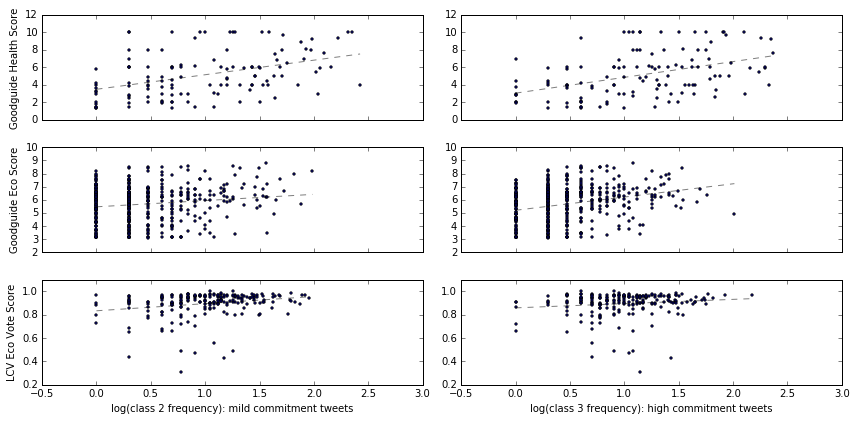

In [45]:
files = [HEALTH_BRANDS_tweet_commitment, ECO_BRANDS_tweet_commitment, ECO_MOCS_tweet_commitment]
#axes = plt.
figure, axes = plt.subplots(3, 2, sharex=True, sharey=False, figsize=(12, 6), tight_layout=True)
for ai, file in enumerate(files):
    print('\n\n\n%s' % file)
    df = pd.read_csv(file, delimiter='\t')
    #df = df[(df.score > 0) & (df.n_tweets_similarity_limit  > 5)]
    df = df[(df.score > 0) & (df.n_c2_thresh + df.n_c3_thresh  > 0)]
    result = smf.ols(formula="score ~ np.log10(1 + n_tweets_similarity_limit) + np.log10(1 + n_c2_thresh) + np.log10(1 + n_c3_thresh)",
                     data=df).fit()
    c2 = np.log10(1 + df.n_c2_thresh)
    c3 = np.log10(1 + df.n_c3_thresh)
    #plt.scatter(c2, df.score, label='c2')
    axes[ai][0].scatter(c2, df.score, marker='.')
    axes[ai][1].scatter(c3, df.score, marker='.')
    axes[ai][0].plot(np.unique(c2), np.poly1d(np.polyfit(c2, df.score, 1))(np.unique(c2)), 'k--', alpha=.5)
    axes[ai][1].plot(np.unique(c3), np.poly1d(np.polyfit(c3, df.score, 1))(np.unique(c3)), 'k--', alpha=.5)
    display(result.summary())
    
axes[-1][0].set_xlabel('log(class 2 frequency): mild commitment tweets')
axes[-1][1].set_xlabel('log(class 3 frequency): high commitment tweets')
axes[0][0].set_ylabel('Goodguide Health Score')
axes[1][0].set_ylabel('Goodguide Eco Score')
axes[2][0].set_ylabel('LCV Eco Vote Score')
plt.show()